In [453]:
import numpy as np
import csv
import pandas as pd
import os
import random 
import math
import timeit
import sys
import statsmodels.api as sm
import scipy.stats as stats

#for the max log likelihood
from scipy.optimize import minimize
#from matplotlib import pyplot as plt
import seaborn as sns

from patsy import dmatrices
import matplotlib.pyplot as plt
plt.style.use('ggplot') #style of figure output

In [14]:
# sys.path.insert(0, '../../../weekly_updates/lib')

In [454]:
def uv_exp_ll(t, mu, alpha, beta, T):
    """
    Likelihood of a univariate Hawkes process with exponential decay.
    :param t: Bounded finite sample of the process up to time T. 1-d ndarray of timestamps
    :param mu: the exogenous intensity
    :param alpha: the infectivity factor alpha
    :param beta: intensity parameter of the delay density
    :param T: the maximum time
    :return: the log likelihood
    """

    phi = 0.
    lComp = -mu * T
    lJ = 0
    N = t.shape[0]
    j = 0

    lComp -= alpha * (1 - math.exp(-beta * (T - t[0])))
    lJ = math.log(mu)

    for j in range(N-1):
        d = t[j+1] - t[j]
        r = T - t[j+1]

        ed = math.exp(-beta * d)  # exp_diff
        try:
            F = 1 - math.exp(-beta * r)
        except: # number is too large
            F = 1 - math.exp(50)

        phi = ed * (1 + phi)
        lda = mu + alpha * beta * phi

        lJ = lJ + math.log(lda)
        lComp -= alpha * F

    return lJ + lComp

In [455]:
def uv_exp_ll_grad(t,  mu,  alpha,  beta,  T):
    """
    Calculate the gradient of the likelihood function w.r.t. parameters mu, alpha, beta

    :param t: Bounded finite sample of the process up to time T. 1-d ndarray of timestamps
    :param mu: the exogenous intensity
    :param alpha: the infectivity factor alpha
    :param beta: intensity parameter of the delay density
    :param T: the maximum time
    :return: the gradient as a numpy.array of shape (3,). Gradients w.r.t. mu, alpha, beta respectively
    """

    phi, nphi = 0, 0
    Calpha,Cbeta = 0,0
    nmu , nalpha , nbeta = 0.,0.,0.
    N = len(t)
    j = 0
    d,r = 0., 0.

    nmu = 1/ mu
    Calpha = 1 - math.exp(-beta * (T - t[0]))
    Cbeta = alpha * (T - t[0]) * math.exp(-beta * (T - t[0]))

    for j in range(N-1):
        d = t[j+1] - t[j]
        r = T - t[j+1]

        ed = math.exp(-beta * d)
        #F = 1 - math.exp(-beta * r)
        try:
            F = 1 - math.exp(-beta * r)
        except: # number is too large
            F = 1 - math.exp(50)

        nphi = ed * (d * (1 + phi) + nphi)
        phi = ed * (1 + phi)
        lda = mu + alpha * beta * phi

        nmu = nmu + 1. / lda
        nalpha = nalpha + beta * phi / lda
        nbeta = nbeta + alpha * (phi - beta * nphi) / lda

        Calpha = Calpha + F
        Cbeta = Cbeta + alpha * r * (1 - F)

    return np.array([nmu - T, nalpha - Calpha, nbeta - Cbeta])

In [7]:
def uv_misd_em_fit(points_hawkes,T,max_time_phi,num_iter=500,reltol=1e-5):
    """
    Implements Time scale separation and EM convergence of univariate Hawkes process
    with exponential decay (Lewis & Mohler, 2011). 

    :param points_hawkes: Bounded finite sample of the process up to time T. 1-d ndarray of timestamps
    :param T: the maximum time
    :param max_time_phi: maximum time on kernel domain
    :param num_iter: int, maximum number of EM iterations
    :param reltol: double, the relative improvement tolerance to stop the algorithm

    :return: 3 lists of parameter estimate (mu, alpha and beta)
    """
    debug = False 
    
    
    #initialising 
    odll = 0.
    odll_p = 0.
    T_phi=max_time_phi

    N = len(points_hawkes)
    P, Pij_flat, tau_phi_md, num_Pij_row = ini_P(points_hawkes,T_phi)

    tau_phi = sum(tau_phi_md,[])
    tau_Pij_flat = [a * b for a, b in zip(tau_phi, Pij_flat)]

    #set
    lamda_mu = sum(np.diag(P))*2/T                #lamda_mu = sum(np.diag(P))/T
    lamda_alpha = sum(Pij_flat)*2/N/T_phi         #lamda_alpha = sum(Pij_flat)/N    
    lambda_beta = sum(Pij_flat)/sum(tau_Pij_flat) #lambda_beta = sum(Pij_flat)/sum(tau_phi)
    odll_p = uv_exp_ll(points_hawkes, lamda_mu, lamda_alpha, lambda_beta, T)

    mu_list=[]
    alpha_list=[] 
    beta_list=[]
    like_list=[]

    #print('update prob matrix')
    for iteration in range(num_iter): #ensure convergence
        Pij_flat=[]
        tau = []
        R_j = [] #expected total number of injuries that cause subsequent injury
        sum_ij = 0

        # E Step, update P 
        mu_ti = lamda_mu
        alpha_ti = lamda_alpha
        beta_ti = lambda_beta
        for j in range(N):
        
            for i in range(j,N):  # lower triangular matrix
                if i == 0: continue ## start from the second row, because the first row of P is always 1'
                tij = points_hawkes[i] - points_hawkes[j] 

                kernel = 0
                for k in range(0,i): #calculate kernel   #for k in range(0,i-1):
                    tik = points_hawkes[i] - points_hawkes[k] 
                    kernel += (alpha_ti * beta_ti * np.exp(-beta_ti *tik))

                if i != j:
                    P[i][j] = (alpha_ti * beta_ti * np.exp(-beta_ti * tij))/(kernel + mu_ti)
                    Pij_flat.append(P[i][j])
                    tau.append(tij)
                    #print('--------')
                    #print(P[i][j])
                    sum_ij += P[i][j]
                    #print(sum_ij)
                else:
                    #kernel = (alpha_ti * beta_ti * np.exp(-beta_ti *tij))
                    P[i][i] = mu_ti/(kernel + mu_ti)
                    #print(i)
                    #print('++++++++++')
                    R_j.append(sum_ij/i)
                    sum_ij = 0
                    #R_j.append(sum_ij) #sum(Pij_flat)) #dynamic reproduction number R(t)
                    #sum_ij = 0
                    #R_j.append(sum(Pij_flat)/i) 

                
        # M Step, update paramters (maximisation)
        tau_Pij_flat = [a * b for a, b in zip(tau, Pij_flat)] #tau_Pij_flat = [a * b for a, b in zip(tau_phi, Pij_flat)] #tau does not change
        lamda_mu = sum(np.diag(P))/T                #lamda_mu = sum(np.diag(P))*2/T                
        lamda_alpha = sum(Pij_flat)/N               #lamda_alpha = sum(Pij_flat)*2/N/T_phi 
        lambda_beta = sum(Pij_flat)/sum(tau_Pij_flat)  # is this right , #lambda_beta = sum(Pij_flat)/sum(tau_phi)

        # calculate observed data log likelihood
        odll = uv_exp_ll(points_hawkes, lamda_mu, lamda_alpha, lambda_beta, T) #here
        relimp = (odll - odll_p) / abs(odll_p)  # relative improvement
        if relimp < -1e-5:
            raise Exception("Convergence problem, the log likelihood did not increase")
        elif relimp < reltol:
            break
        odll_p = odll

        # record
        mu_list.append(lamda_mu)
        alpha_list.append(lamda_alpha)
        beta_list.append(lambda_beta)
        like_list.append(odll)

        #checks --
        if debug:
            print('mu: '+str(lamda_mu)+ ', alpha: '+str(lamda_alpha)+', beta: '+str(lambda_beta))
        # all elements should equal 1
        sum_rows =[]
        for i in range(N):
            sum_rows.append(sum(P[i]))

    #branching structure
    B = np.zeros_like(P)
    B[np.arange(len(P)), P.argmax(1)] = 1
    
    
    #check
    sum_dia_B = sum(np.diag(B))
    #sum_cros_dia_b = sum(B) - sum_dia_B

    if debug:
        print(R_j)
        print('----------')
        print(points_hawkes)
        print('----------')
        print(P)
        print('==========')
        print(B)
        print('==========')
        print(sum_dia_B)

    return mu_list,alpha_list,beta_list,like_list,P

In [456]:
def ini_P(points_hawkes,T_phi):
    r"""
    Initialize the probabilistic branching matrix. 
    :rtype: numpy array
    :return: probabilistic branching matrix, the flattened P_ij, interval of timestamps :\tau, the number of P_ij!=0 in each row 
    """
    N = len(points_hawkes)
    P = np.zeros((N,N))
    Pij_flat = []
    tau = []
    num_Pij_row = []
    for i in range(N):                    # initial value of P
        for j in range(i+1):
            tij = points_hawkes[i] - points_hawkes[j]
            if tij >= T_phi: continue
            else:
                P[i][j:i+1] = np.random.dirichlet([1]*(i-j+1))
                Pij_flat += list(P[i][j:i])
                tau.append(list(points_hawkes[i] - np.array(points_hawkes[j:i])))
                num_Pij_row.append(i-j)
    return P, Pij_flat, tau, num_Pij_row

In [457]:
def _fit_grad_desc_mess(t, T=None):
    """
    Given a bounded finite realization on [0, T], fit parameters with line search (L-BFGS-B).

    :param t: Bounded finite sample of the process up to time T. 1-d ndarray of timestamps. must be
    sorted (asc). dtype must be float.
    :param T: (optional) maximum time. If None, the last occurrence time will be taken.

    :return: the optimization result
    :rtype: scipy.optimize.optimize.OptimizeResult
    """

    N = len(t)
    ress = []
    
    # due to a convergence problem, we reiterate until the unconditional mean starts making sense
    for epoch in range(5):
        # estimate starting mu via the unconditional sample formula assuming
        # $\alpha \approx 0.2$
        mu0 = N * 0.8 / T

        # initialize other parameters randomly
        a0, th0 = np.random.rand(2)
        # todo: initialize th0 better ?
        myfactr = 1e2
        cb = CallbackFunctor(lambda x: -uv_exp_ll(t, x[0], x[1], x[2], T)) #save iterations
        minres = minimize(lambda x: -uv_exp_ll(t, x[0], x[1], x[2], T),
                        x0=np.array([mu0, a0, th0]),
                        jac=lambda x: -uv_exp_ll_grad(t, x[0], x[1], x[2], T),
                        bounds=[(1e-10, None), (1e-10, 1), (1e-10, None)],
                        callback=cb,
                        #method="Nelder-Mead",  options={"disp": False,"gtol": 1e-8})
                        #method="Newton-CG",  options={"disp": False, "ftol": myfactr * np.finfo(float).eps, "gtol": 1e-8})
                        method="L-BFGS-B", options={"disp": False, "ftol": myfactr * np.finfo(float).eps, "gtol": 1e-8})
        #Debug
        #print(cb.best_sols)       # contains all your collected solutions
        #print(cb.best_fun_vals)   # contains the corresponding objective function values

        #cb.save_sols("dummy.txt") # writes all solutions to a file 'dummy.txt'      
        ress.append(minres)
        mu, a, _ = minres.x
        mess = minres.message
        iter_min = minres.nit

        # take the unconditional mean and see if it makes sense
        #Napprox = mu * T / (1 - a)   
        Napprox = mu * T / (1.5 - a)   
        
        if abs(Napprox - N)/N < .01:  # if the approximation error is in range, break
            break
    
    #lik =  -uv_exp_ll(t, mu, a, _, T)
    return mu, a, _, iter_min,mess,cb.best_fun_vals[:-1],cb.best_sols[:-1]#obj_fun_lst # remove this
    #return mu, a, _, iter_min,lik,mess 

In [458]:
def plot_fit(path,filename, title,smp,max_time,mu,alpha,beta,iter_neg_ll,save_file = True):
    '''
    Saves plots. Intensity, MLE/MISD parameter estimates and goodeness of fit
    '''
    line_col = 'dimgrey' #'#1f77b4'
    fig_x = 20
    fig_y = 4
    
    f, axs = plt.subplots(1, 3,figsize=(fig_x,fig_y))
    f.suptitle(title)
    #intensity
    lda_ar = [mu + np.sum(alpha * beta * np.exp(-beta * (x - smp[smp < x]))) \
             for x in np.arange(0, max_time, .1)]

    axs[0].set_title('')
    axs[0].set_ylabel("$\lambda^*(t)$")
    axs[0].set_xlabel("$t$")
    #axs[0].plot(smp, np.ones_like(smp) * .1, 'k.',label="arrivals")
    axs[0].plot(smp, np.ones_like(smp) * min(lda_ar), 'k.',label="arrivals")
    axs[0].plot(np.arange(0, max_time, .1), lda_ar, color= line_col ,label="$\lambda^*(t)$")#'b-' ##ff7f0e orange
    #axs[0].legend(loc='upper left')

    #axs[1].set_title('Parameter Estimation')
    axs[1].set_title('')
    axs[1].plot(iter_neg_ll)
    axs[1].set_ylabel('neg LL')
    axs[1].set_xlabel('iterations')
    tau =  np.empty(len(smp), dtype=np.float64)
    t_pre = 0
    for i, t_i in enumerate(smp):
        tau[i] = t_i - t_pre
        t_pre = t_i
    stats.probplot(tau, dist="expon", plot=plt)
    axs[1].get_lines()[0].set_color(line_col) #change line red to line color specified

    #axs[2].set_title('QQ Plot')
    axs[2].set_title('')
    axs[2].get_lines()[0].set_color('black') ##1f77b4
    axs[2].get_lines()[0].set_markersize(3)
    axs[2].get_lines()[1].set_color(line_col)
    axs[2].set_ylabel(r'ordered $\tau$')
    axs[2].set_xlabel('theoretical quantiles')

    if save_file:
        #output
        plt.savefig(os.path.join(path,'individual\\misd\\'+filename+'.png'), bbox_inches='tight')
    else:
        plt.show()
        #uv_exp_forcast_nt(file_path,file_name, T, mu,  alpha,  beta, smp )
    return

In [459]:
def assess_players_misd(players_lst,return_debug_para = False, save_file = True):
    """_summary_

    Args:
        players_lst (list): List of players name to estimate.e.g ['Player 10','Player 12','Player 13'...]
        return_debug_para (bool, optional): Return single list of list (false) or iterations paramters(true). Defaults to False.
    Requirment:
        D5_cols_to_use.xlsx file with player injuries times.
    """

    read_sheet = 'Sheet 1' 
    parent_dir = os.getcwd()
    player_data = parent_dir + '/D5_cols_to_use.xlsx'
    with pd.ExcelFile(player_data) as reader:
        sheet_injury = pd.read_excel(reader, sheet_name=read_sheet)
    #sort values
    sort_inj = sheet_injury.sort_values(['Player', 'Date'], ascending=[True, True])
    sort_inj.replace(0.0, np.nan, inplace=True)

    mu_est,alpha_est,beta_est,neg_ll_est,p_mat_est,all_para_est,smp_all = [],[],[],[],[],[],[]
    player_valid_est,player_err_est = [],[]
    for player in players_lst:
        print(player +' estimating ....')
        
        #extract player data, sort/index and determing months duration of injury
        player_stat = sheet_injury.loc[sheet_injury['Player'] == player]
        player_stat_sort = player_stat.sort_values(by='Date')
        smp_inj = player_stat_sort.drop(player_stat_sort[player_stat_sort['Injury Type'] == 'NoInjury'].index)
        
        #if less than minimum require of injuries skip
        if len(smp_inj) < 6:
            print(player +' has too few records. Only '+ str(len(smp_inj)) + ' injuries!' )
            continue
            
        smp_inj.reset_index(drop=True, inplace=True)
        smp_inj['months'] = ((smp_inj['Date'] - smp_inj['Date'][0])/np.timedelta64(1, 'M'))
        smp_inj = smp_inj['months'].to_numpy()
        max_time = int(smp_inj[-1])+1 #32 months  

        #print(np.diff(smp_inj)) #tau's
        smp_inj = np.delete(smp_inj, 0) #removes first element
        smp = np.array(smp_inj)
        max_t=max_time 
        print('max time: ' + str(max_t))
        print(smp_inj)
        
        try:
            mu_lst,alpha_lst,beta_lst,iter_neg_ll,p_matrix = uv_misd_em_fit(smp_inj,max_time,6)
        except Exception:
            print(player +' has convergence issues, no valid estimate.')
            player_err_est.append(player)
            continue
        
        player_valid_est.append(player)
            
        title = player.replace(" ", "_").lower() + ' MISD (mu:'+str(round(mu_lst[-1],4))+', alpha:'+str(round(alpha_lst[-1],4)) + \
                ', beta:'+str(round(beta_lst[-1],4))+')'
        filename = player.replace(" ", "_").lower() + '_MISD' 

        plot_fit(parent_dir,filename, title, smp,max_time,
                 mu_lst[-1],alpha_lst[-1],beta_lst[-1],iter_neg_ll,save_file)
        
        #return values
        if return_debug_para:
            mu_est.append(mu_lst)
            alpha_est.append(alpha_lst)
            beta_est.append(beta_lst)
            neg_ll_est.append(iter_neg_ll)
            p_mat_est.append(p_matrix)
            smp_all.append(smp_inj)
        else:
            all_para_est.append([player,mu_lst[-1],alpha_lst[-1],beta_lst[-1]])
        
    if return_debug_para:
        return mu_est,alpha_est,beta_est,p_mat_est,neg_ll_est, player_valid_est,player_err_est,smp_all
        
    return all_para_est

In [460]:
def diagonal_mass_info(p_matrix,smp_all,mu_lst,player_valid_est,tol = 0.5):
    """
    diagonal_mass_info report values for pmatrix

    :param smp_all: Bounded finite sample of the process up to time T. 1-d ndarray of timestamps
    :player_valid_est T: Name of player
    :tol: defaults to 14 days (0.460273  months)
    :return: Dataset & Diagonal Mass & Background Rate & Number of Offspring & Number of 14 Day Offspring \
    Percent of Offspring in First 2 Weeks
    """
    
    #Numeric summaries ofimplementing the MISD algorithm for each data set for latex table
    print('Player & Diagonal Mass & Background Rate & No. of offspring & Number of ' \
          + str(tol) +' months Offspring  & Per. of Offspring in first ' + str(tol) +' Months \\\ ')

    for i in range(len(p_matrix)):
        
        P = p_matrix[i]
        
        #Classification (child/parent) - assign offspring based on probability matrix 
        B = np.zeros_like(P)
        #B[np.arange(len(P)), P.argmax(1)] = 1 #argmax implemntation 
        for j in range(len(P)): #np.random choice implementation
            row_prob = P[j]
            row_prob /= row_prob.sum() #normalise - ensure random choice works
            val = np.random.choice(len(row_prob), 1,  p=row_prob)[0] 
            B[j,val] = 1
            
        #diagonal mass
        #dig_mass = np.trace(B) / len(B) #diagonal mass base on classification (parent)
        dig_mass =  np.trace(p_matrix[i])/np.sum(p_matrix[i]) #diagonal mass base on probabilities

        if np.sum(B) - np.trace(B) != 0: #there is atleast 1 child
            no_offspring = (np.sum(B) - np.trace(B)) 
            no_offspring_per_mass = no_offspring/np.sum(B)

            #Number of Offspring within tols days (tolerece)
            smp = smp_all[i]
            tau_child = []
            for j in range(len(B)):
                for k in range(j+1):
                    if B[j][k] == 1:
                        if j != k:
                            #debuging
                            #print('j:'+str(j)+' k:'+str(k))
                            #print('event '+str(j)+' caused by '+str(k))
                            #print('event '+str(smp[j])+' caused by '+str(smp[k])+' | tau:' + str(round(smp[j] - smp[k],4)))                            
                            tau_child.append(round(smp[j] - smp[k],4))
                            
            num_of_child_tol = sum(x < tol for x in tau_child) 
            num_of_child_tol_per_mass = num_of_child_tol/np.sum(B)
            num_of_child_tol_per_mass_mass_off = num_of_child_tol_per_mass/no_offspring_per_mass
        else:
            no_offspring_per_mass = 0
            num_of_child_tol_per_mass = 0 
            num_of_child_tol_per_mass_mass_off = 0 

        print('%s & %s\%% & %s & %s & %s & %s\%% \\\ ' % (str(player_valid_est[i]), str(round(dig_mass*100,2)),
              str(round(mu_lst[i:][0][-1],4)), str(round(no_offspring_per_mass,4)),
              str(round(num_of_child_tol_per_mass,4)),str(round(num_of_child_tol_per_mass_mass_off*100,2))
             ))

In [465]:
#individual parameter estimate
#all_para_est = assess_players_misd(['Player 16'])
mu_lst_1,alpha_lst_1,beta_lst_1,p_matrix_1,neg_ll_lst_1,player_valid_est_1,player_err_est_1,smp_all_1 = \
assess_players_misd(['Player 53'], True,False) #assess_players_misd(['Player 17'], True,False) #assess_players_misd(['Player 16'], True,False)

Player 53 estimating ....
max time: 53
[ 0.95279164  3.41690794 16.23031274 22.27561141 23.45838724 24.41117887
 24.83829237 25.75822912 26.25105238 38.14452042 39.95153905 45.04404608
 45.50401446 48.95377728 52.14070104]
Player 53 has convergence issues, no valid estimate.


In [340]:
diagonal_mass_info(p_matrix_1,smp_all_1,mu_lst_1,player_valid_est_1)
diagonal_mass_info(p_matrix_1,smp_all_1,mu_lst_1,player_valid_est_1,tol = 0.75)
diagonal_mass_info(p_matrix_1,smp_all_1,mu_lst_1,player_valid_est_1,tol = 1)
diagonal_mass_info(p_matrix_1,smp_all_1,mu_lst_1,player_valid_est_1,tol = 2)
#Dataset & Diagonal Mass & Background Rate & Number of Offspring & Number of 2 months Offspring     Percent of Offspring in First 2 Months 
#Player 16 & 44.44 & 0.2023 & 0.5556 & 0.1111 & 20.0\% \\ 
#Player 16 & 55.56 & 0.2023 & 0.4444 & 0.3333 & 75.0\% \\ 
#Player 16 & 44.44 & 0.2023 & 0.5556 & 0.3333 & 60.0\% \\ 
#Player 16 & 55.56 & 0.2023 & 0.4444 & 0.4444 & 100.0\% \\ 

Player & Diagonal Mass & Background Rate & No. of offspring & Number of 0.5 months Offspring  & Per. of Offspring in first 0.5 Months \\ 
Player 16 & 51.68\% & 0.2023 & 0.4444 & 0.3333 & 75.0\% \\ 
Player & Diagonal Mass & Background Rate & No. of offspring & Number of 0.75 months Offspring  & Per. of Offspring in first 0.75 Months \\ 
Player 16 & 51.68\% & 0.2023 & 0.6667 & 0.5556 & 83.33\% \\ 
Player & Diagonal Mass & Background Rate & No. of offspring & Number of 1 months Offspring  & Per. of Offspring in first 1 Months \\ 
Player 16 & 51.68\% & 0.2023 & 0.6667 & 0.6667 & 100.0\% \\ 
Player & Diagonal Mass & Background Rate & No. of offspring & Number of 2 months Offspring  & Per. of Offspring in first 2 Months \\ 
Player 16 & 51.68\% & 0.2023 & 0.4444 & 0.4444 & 100.0\% \\ 


In [341]:
players_more_5_injuries = ['Player 10','Player 12','Player 13','Player 15','Player 16','Player 17','Player 18','Player 19',
           'Player 2','Player 20','Player 21','Player 22','Player 23','Player 24','Player 25','Player 27',
           'Player 28','Player 29','Player 3','Player 30','Player 31','Player 32','Player 34',
           'Player 35','Player 38','Player 39','Player 4','Player 40','Player 41',
           'Player 42','Player 43','Player 44','Player 45','Player 46','Player 47','Player 48','Player 49',
           'Player 50','Player 52','Player 53','Player 54','Player 56','Player 57','Player 58','Player 59',
           'Player 6', 'Player 60','Player 61','Player 62','Player 63','Player 64','Player 65','Player 66',
           'Player 67','Player 68','Player 69', 'Player 71','Player 72','Player 7','Player 70','Player 73',
           'Player 75','Player 8']

Player 10 estimating ....
Player 12 estimating ....
Player 13 estimating ....
Player 15 estimating ....
player_15 has convergence issues, no valid estimate.
Player 16 estimating ....
Player 17 estimating ....
player_17 has convergence issues, no valid estimate.
Player 18 estimating ....
Player 19 estimating ....
Player 2 estimating ....
Player 20 estimating ....
player_20 has convergence issues, no valid estimate.
Player 21 estimating ....
Player 22 estimating ....
Player 23 estimating ....
Player 24 estimating ....
Player 25 estimating ....
Player 27 estimating ....
Player 28 estimating ....
Player 29 estimating ....
player_29 has convergence issues, no valid estimate.
Player 3 estimating ....
player_3 has convergence issues, no valid estimate.
Player 30 estimating ....
player_30 has convergence issues, no valid estimate.
Player 31 estimating ....
player_31 has convergence issues, no valid estimate.
Player 32 estimating ....
Player 34 estimating ....
Player 35 estimating ....
player_3

C:\Users\User\AppData\Local\Temp\ipykernel_7584\1490113993.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f, axs = plt.subplots(1, 3,figsize=(fig_x,fig_y))


Player 43 estimating ....
player_43 has convergence issues, no valid estimate.
Player 44 estimating ....
Player 45 estimating ....
player_45 has convergence issues, no valid estimate.
Player 46 estimating ....
player_46 has convergence issues, no valid estimate.
Player 47 estimating ....
Player 48 estimating ....
Player 49 estimating ....
Player 50 estimating ....
Player 52 estimating ....
Player 53 estimating ....
player_53 has convergence issues, no valid estimate.
Player 54 estimating ....
Player 56 estimating ....
Player 57 estimating ....
Player 58 estimating ....
Player 59 estimating ....
Player 6 estimating ....
Player 60 estimating ....
Player 61 estimating ....
player_61 has convergence issues, no valid estimate.
Player 62 estimating ....
Player 63 estimating ....
Player 64 estimating ....
Player 65 estimating ....
Player 66 estimating ....
Player 67 estimating ....
Player 68 estimating ....
Player 69 estimating ....
Player 71 estimating ....
player_71 has convergence issues, 

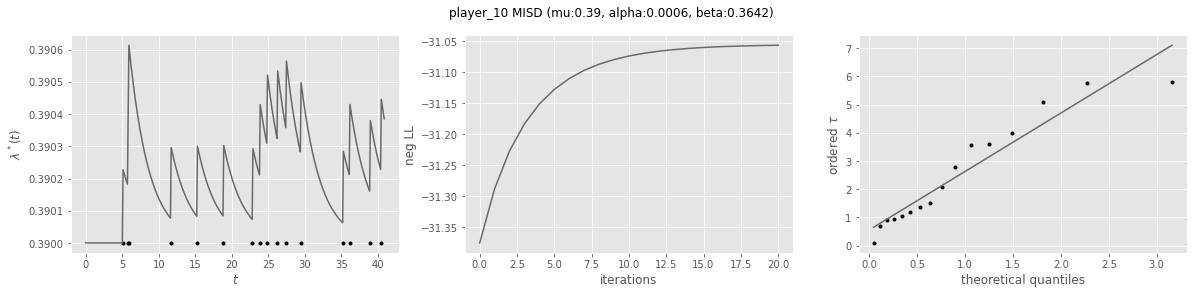

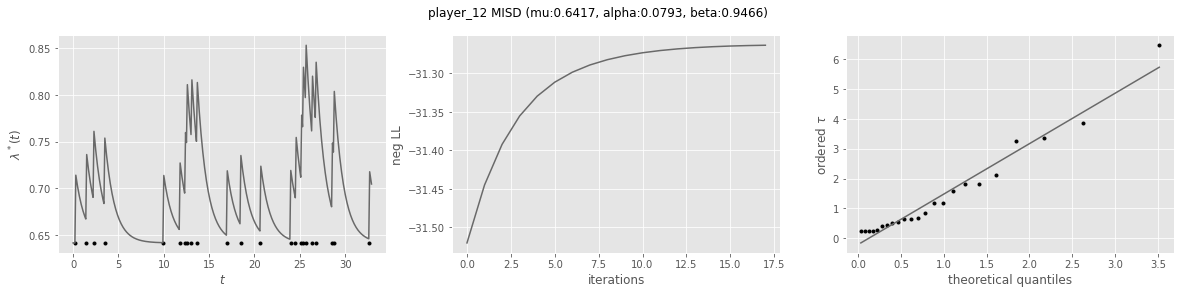

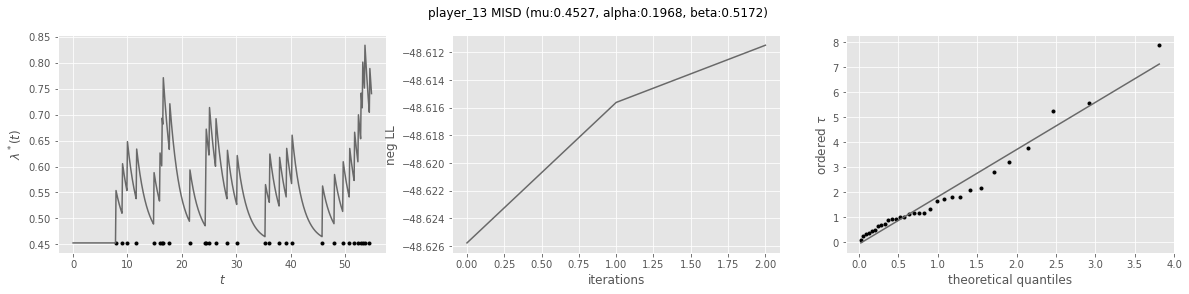

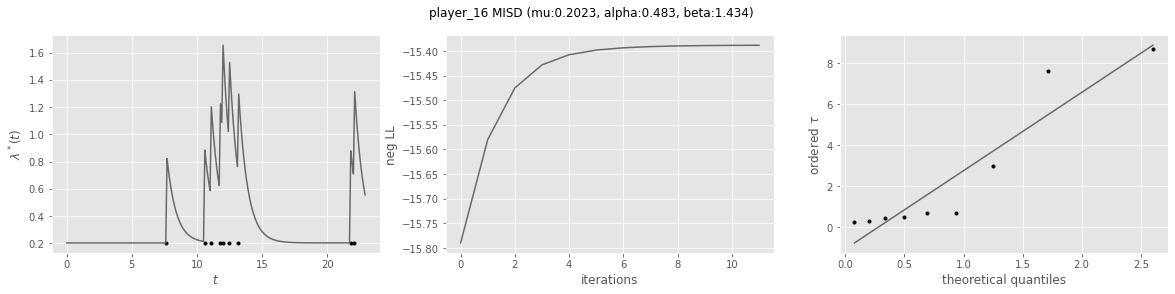

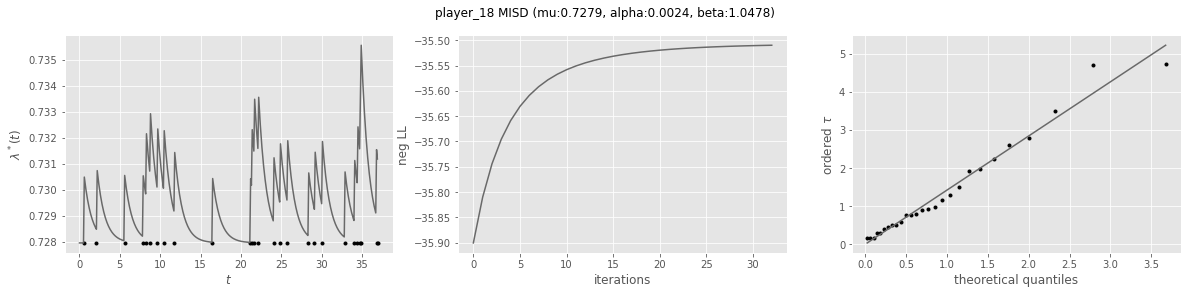

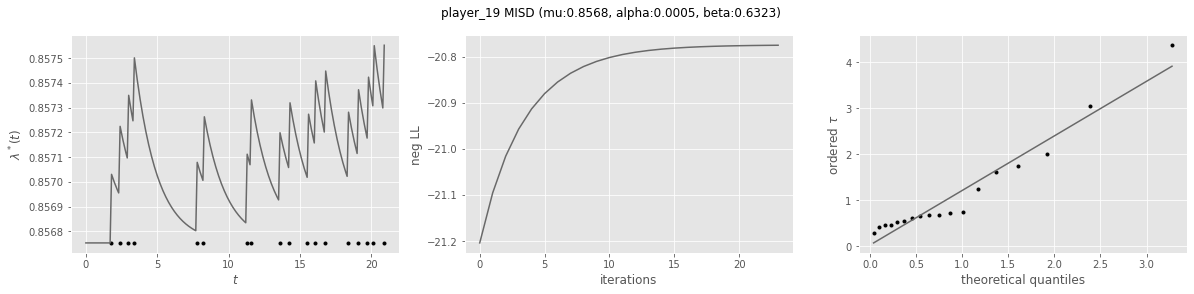

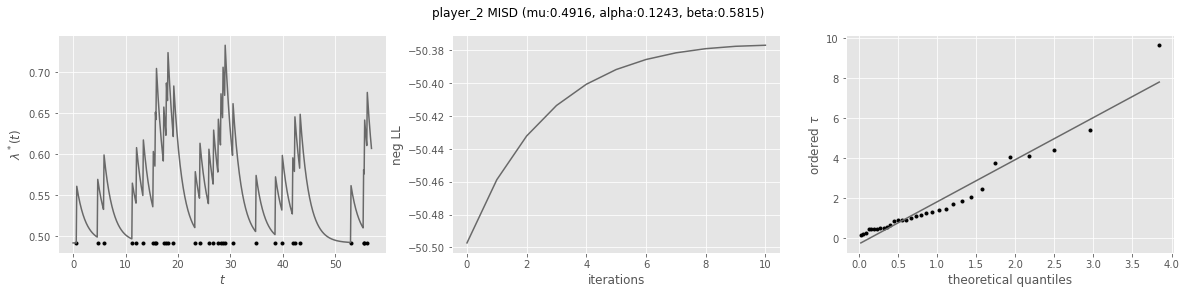

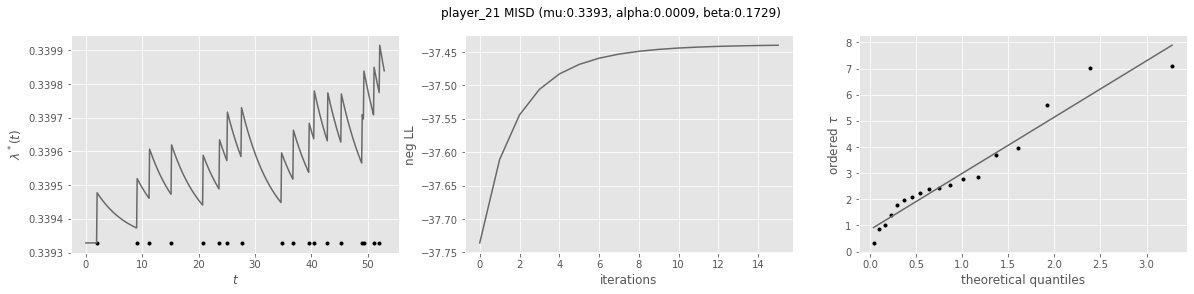

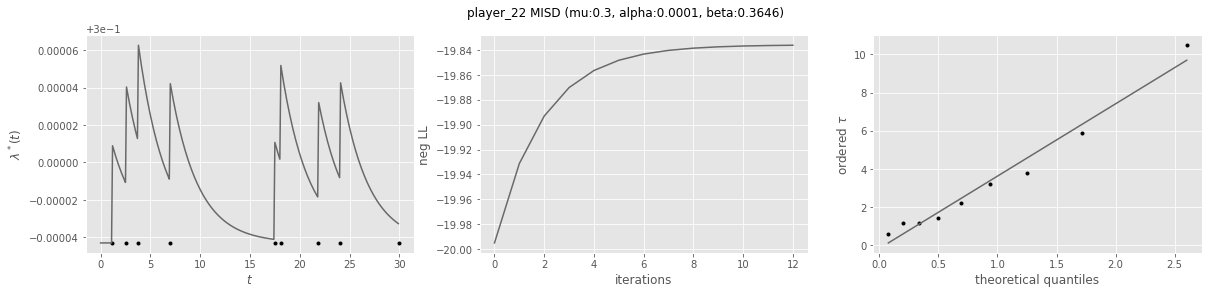

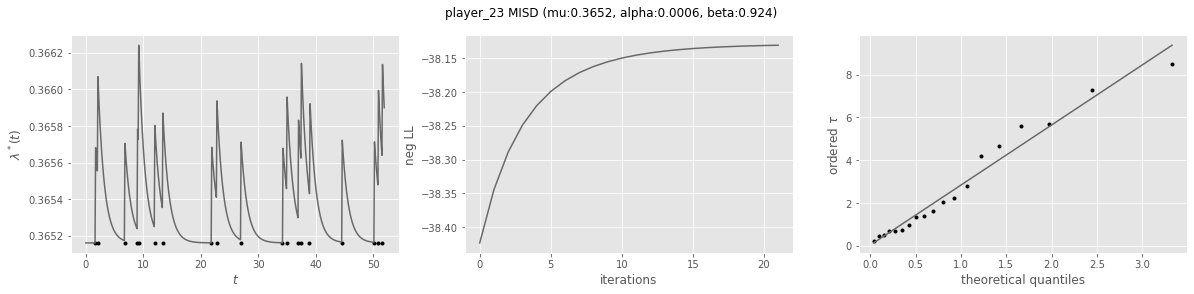

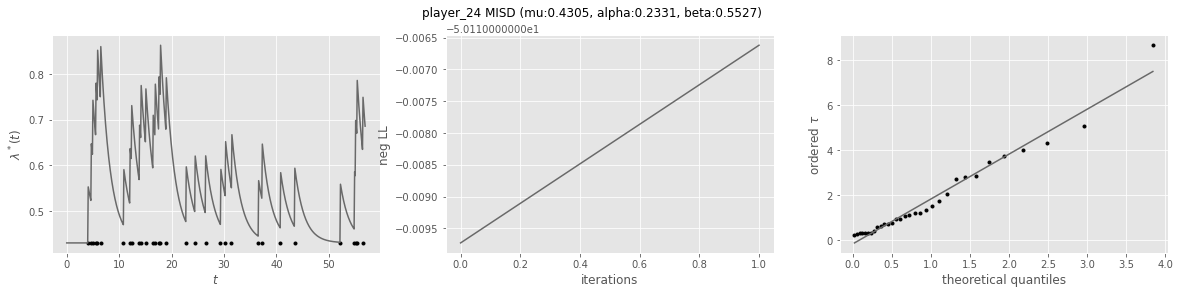

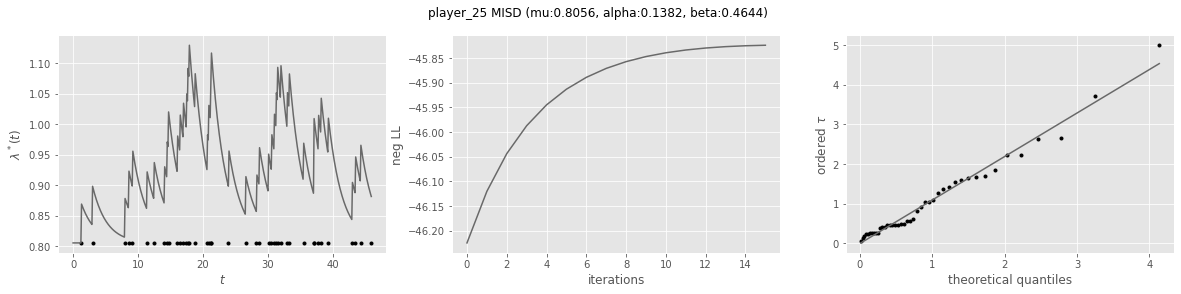

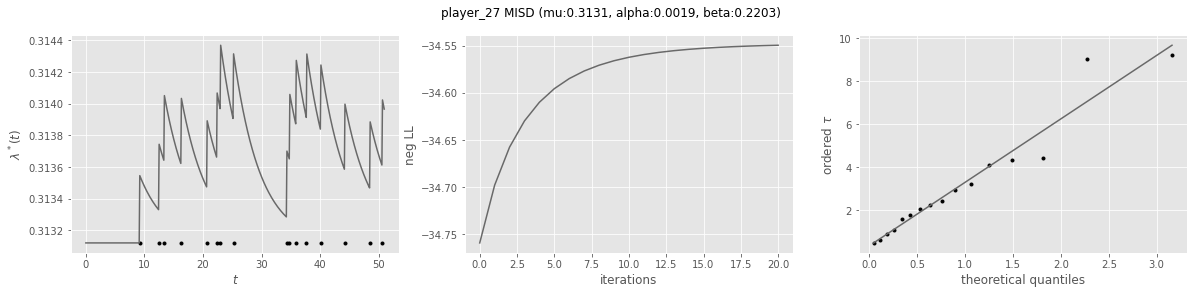

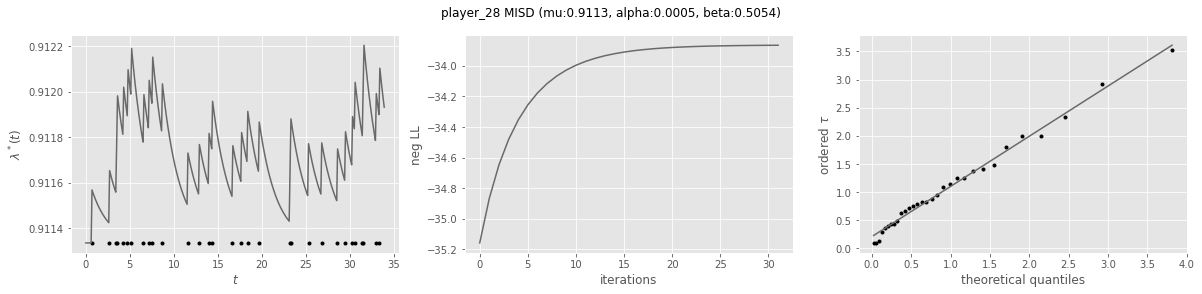

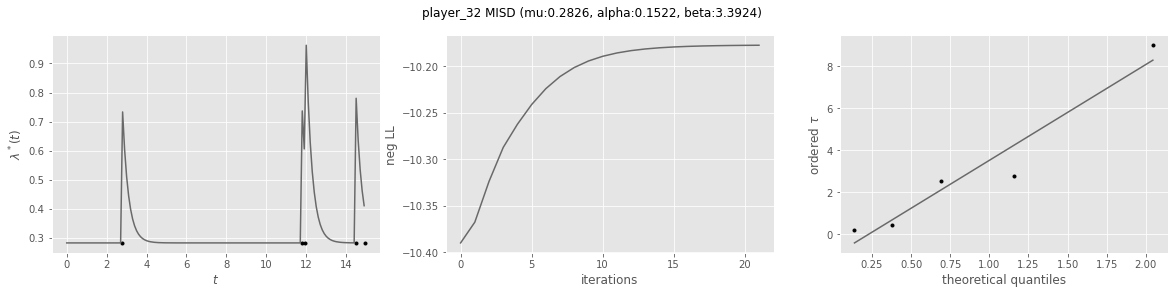

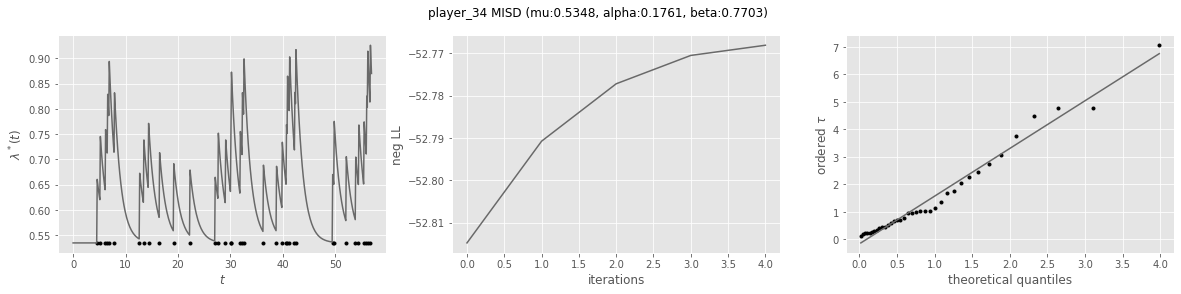

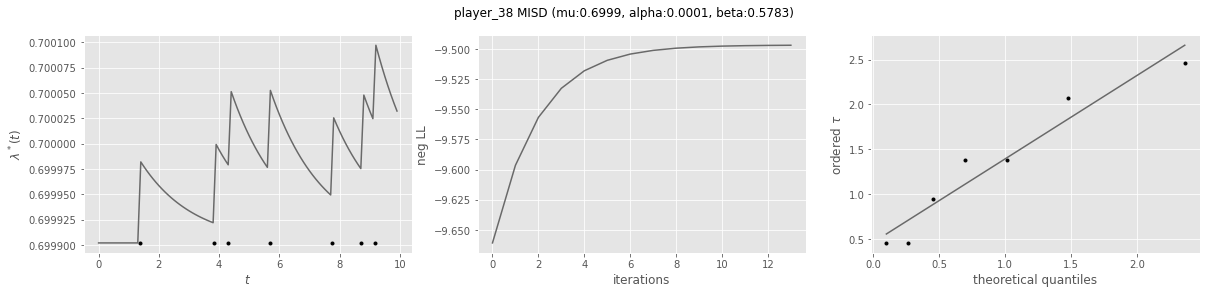

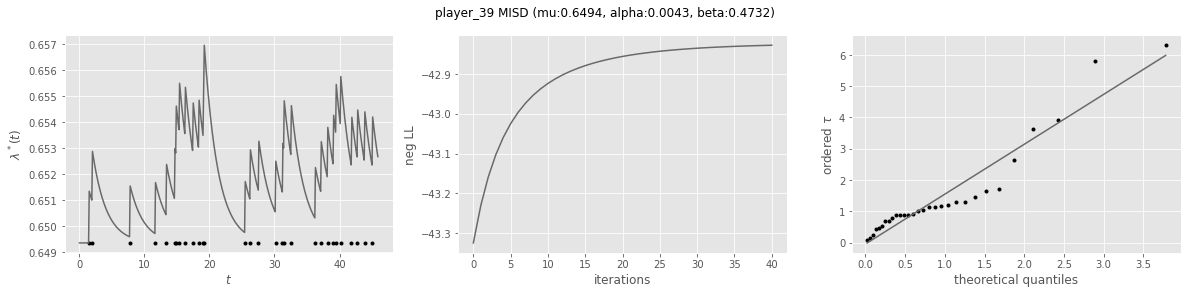

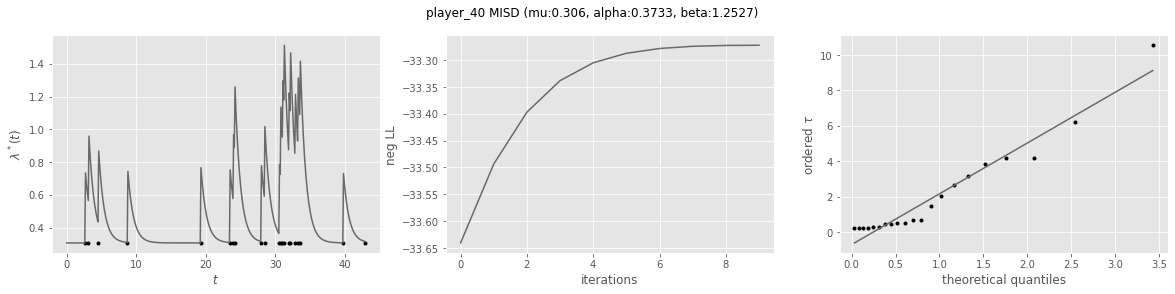

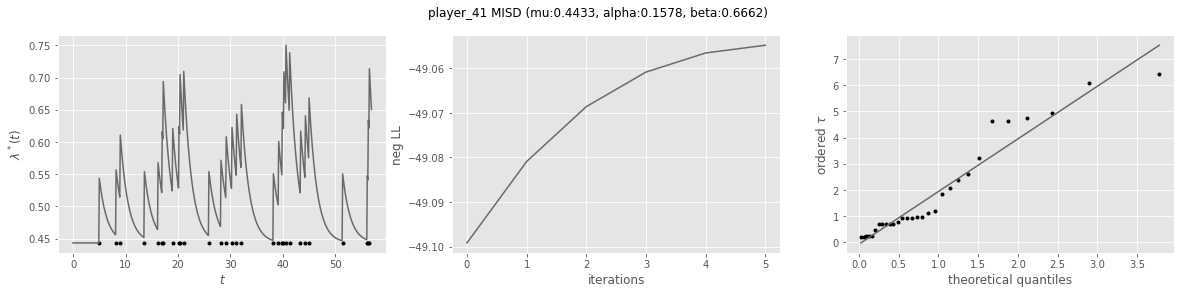

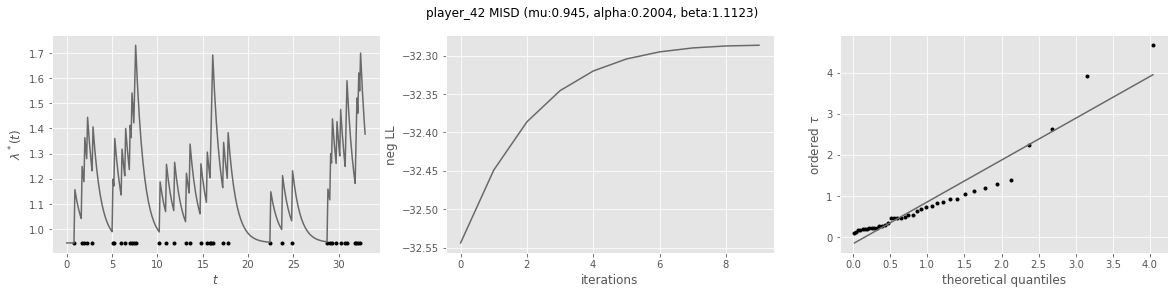

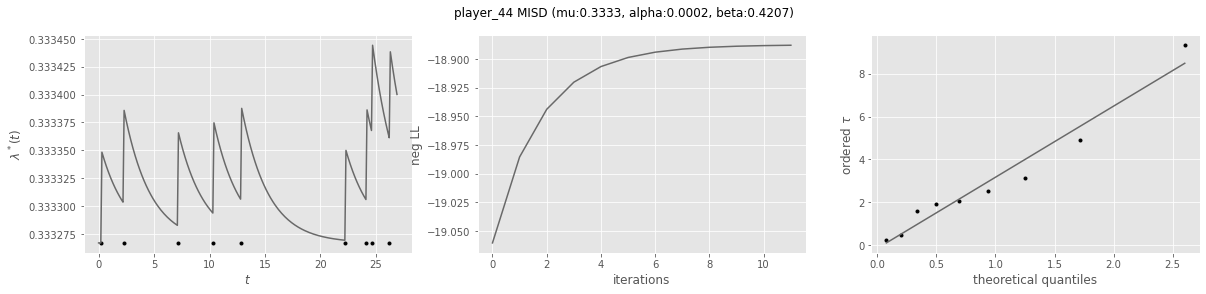

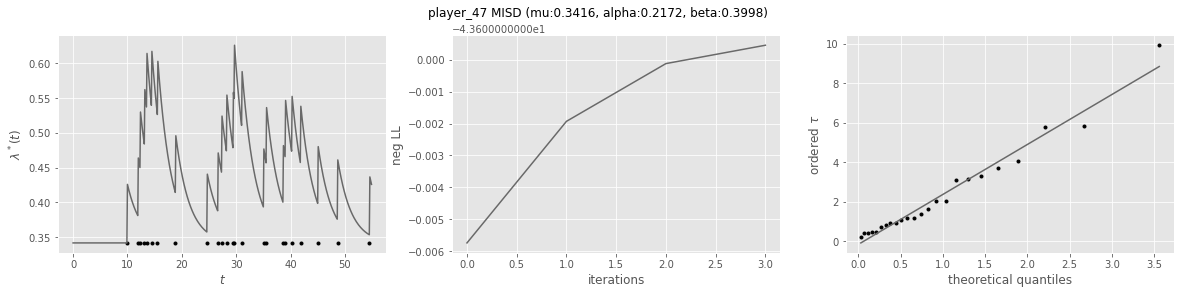

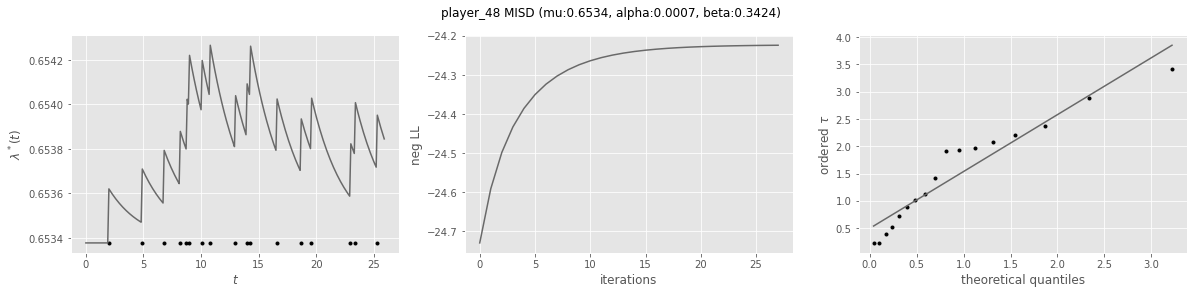

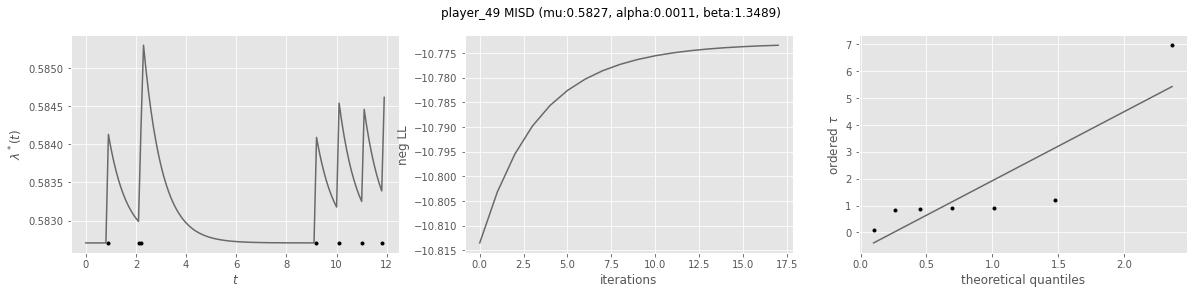

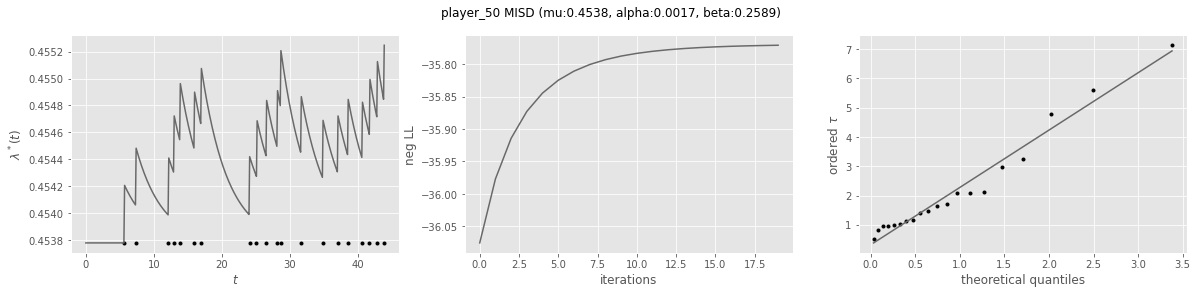

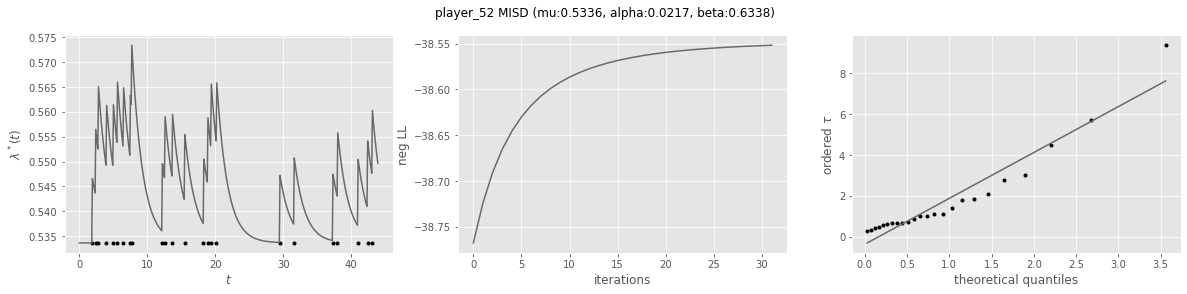

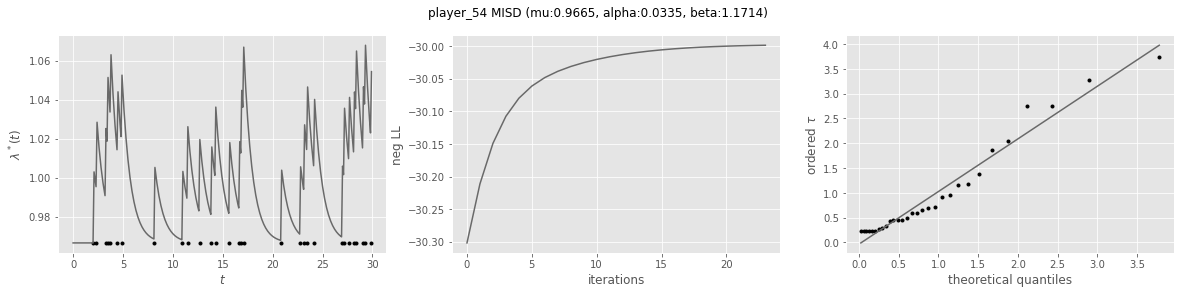

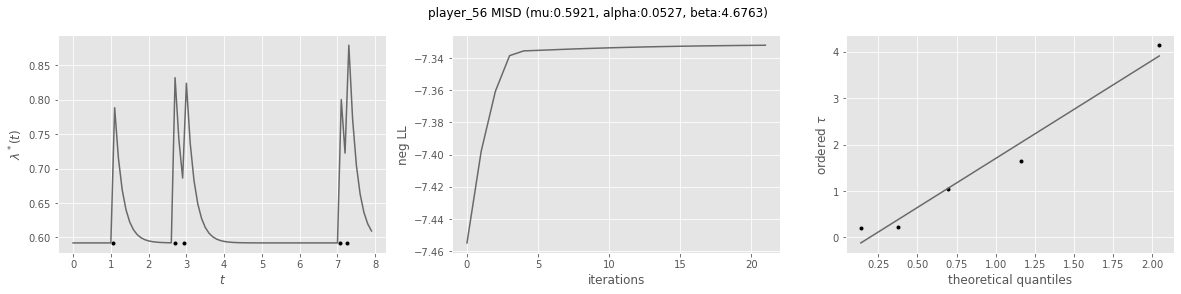

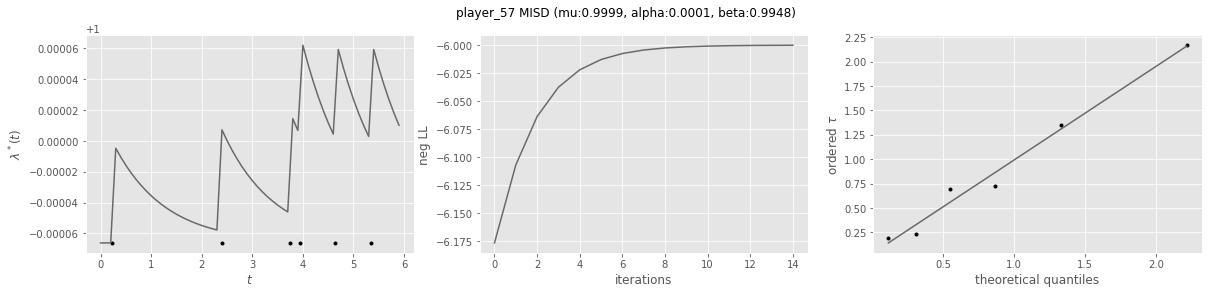

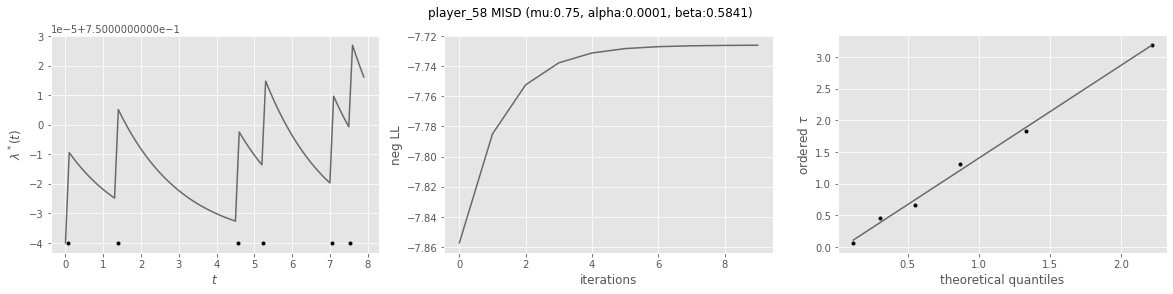

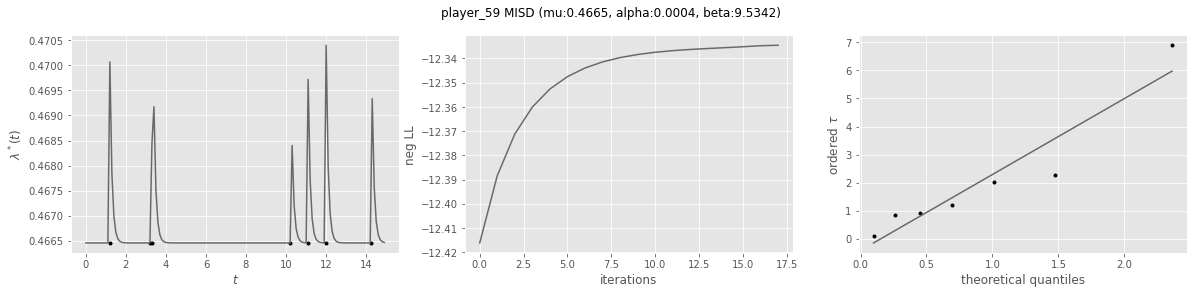

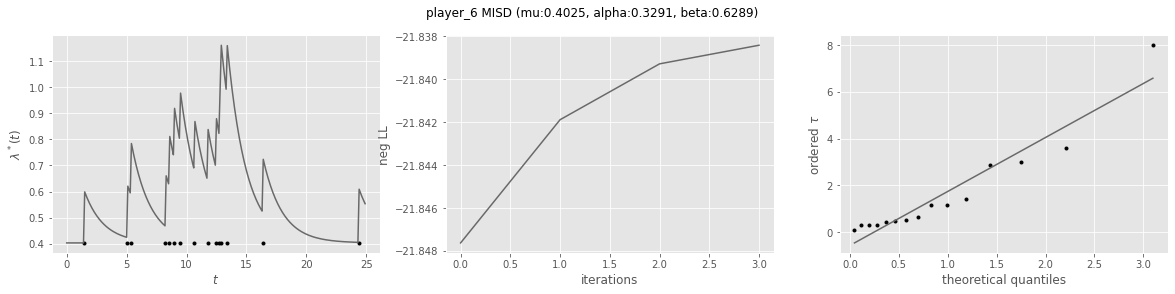

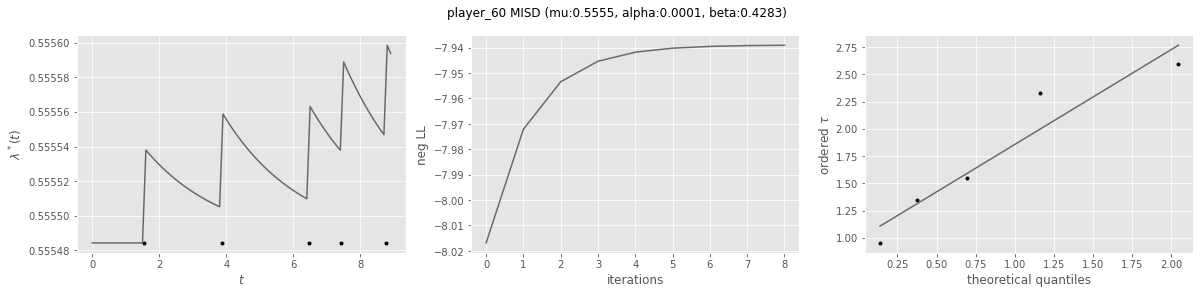

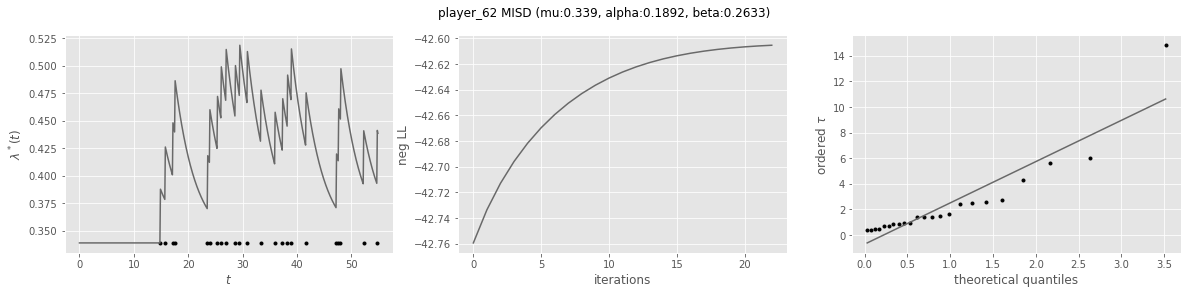

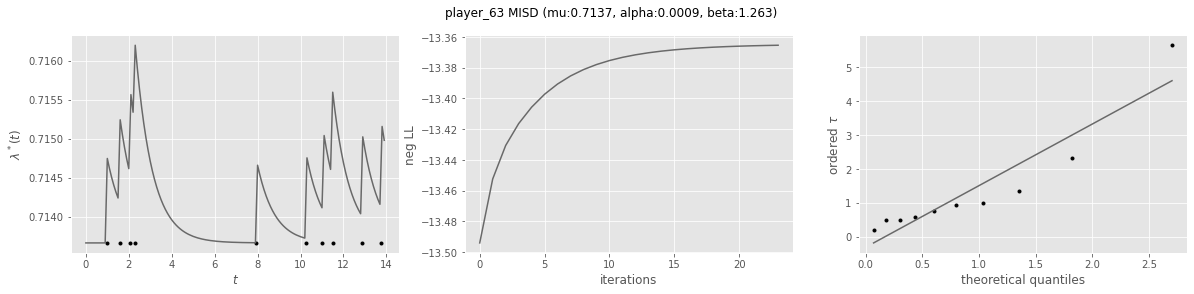

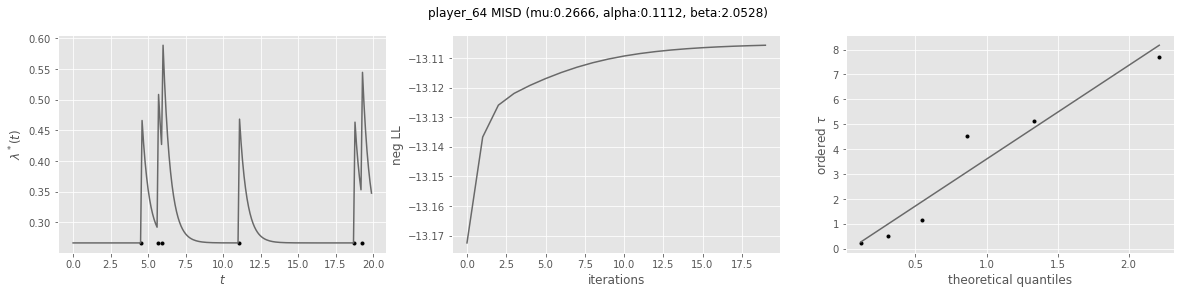

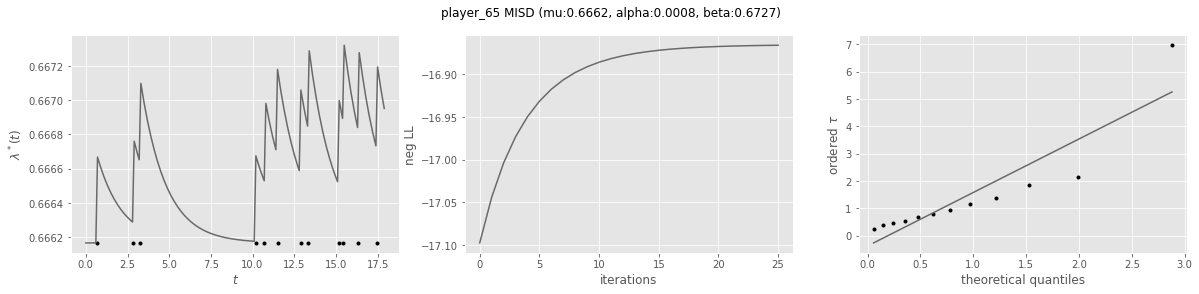

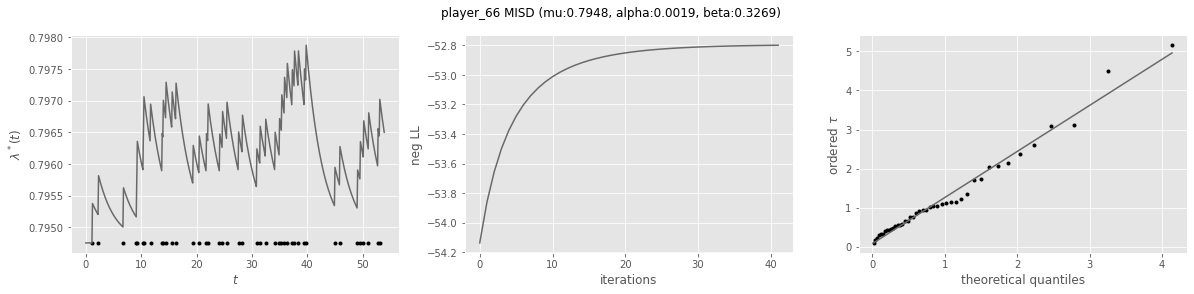

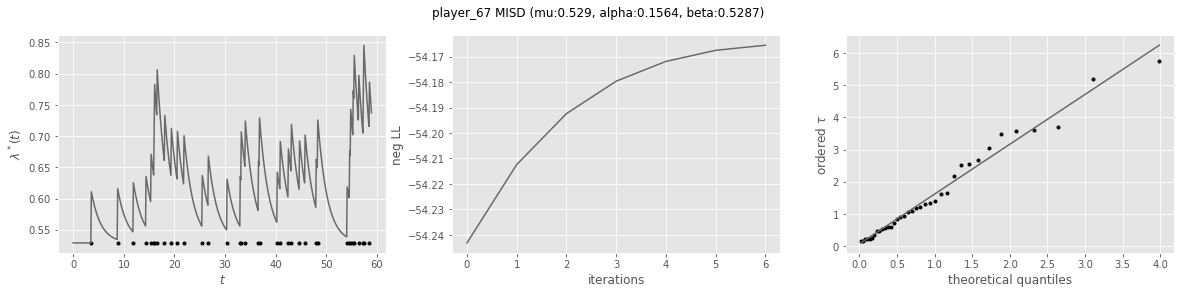

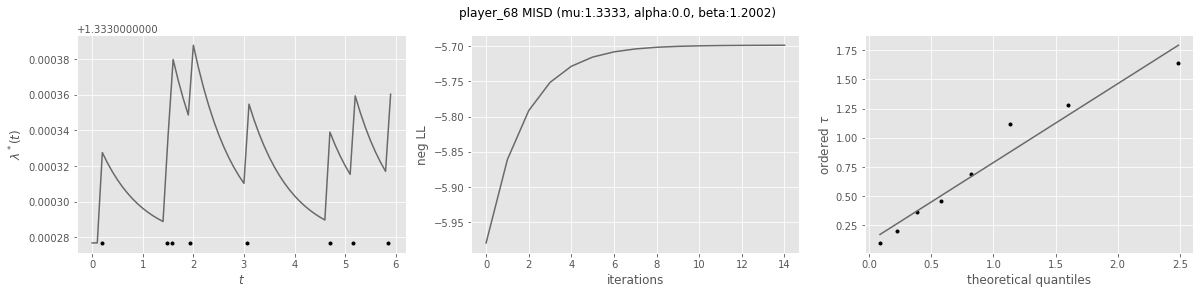

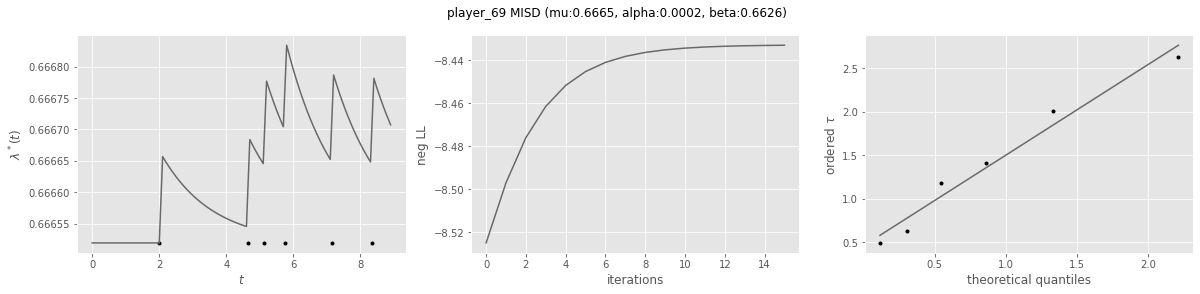

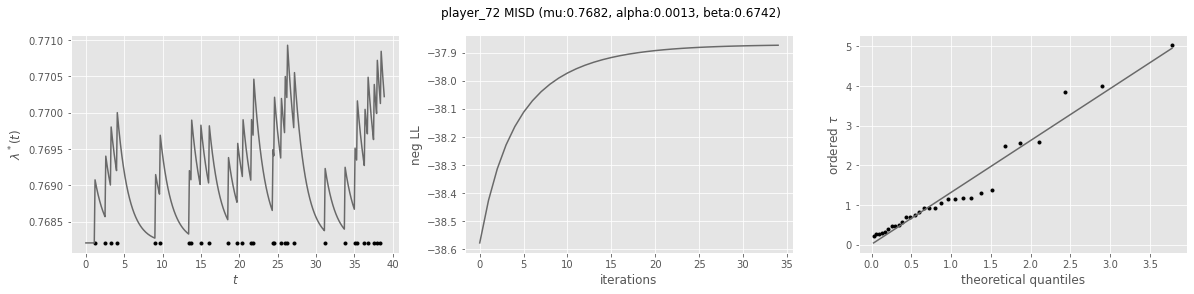

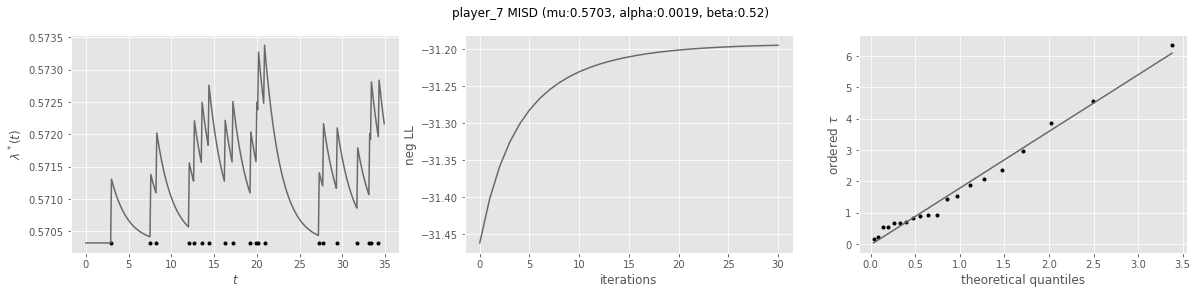

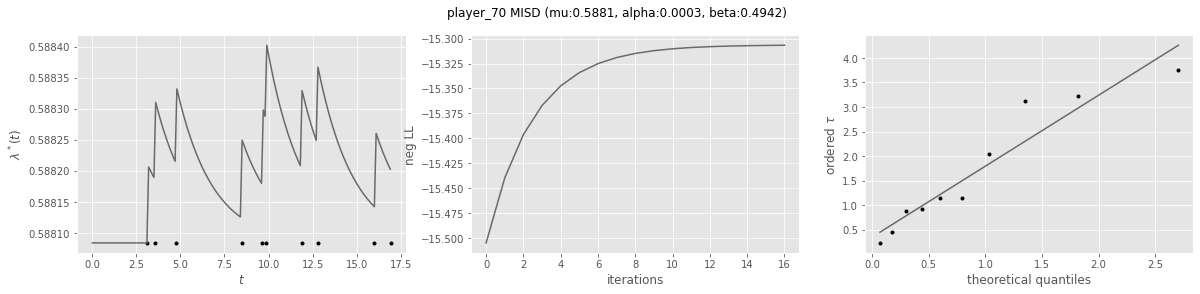

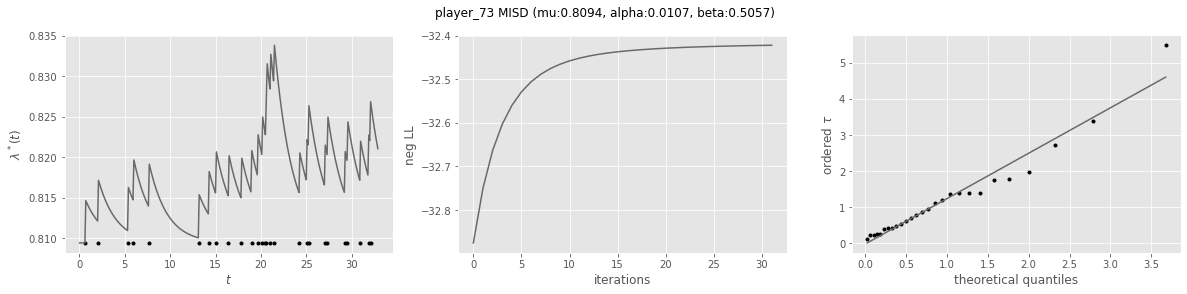

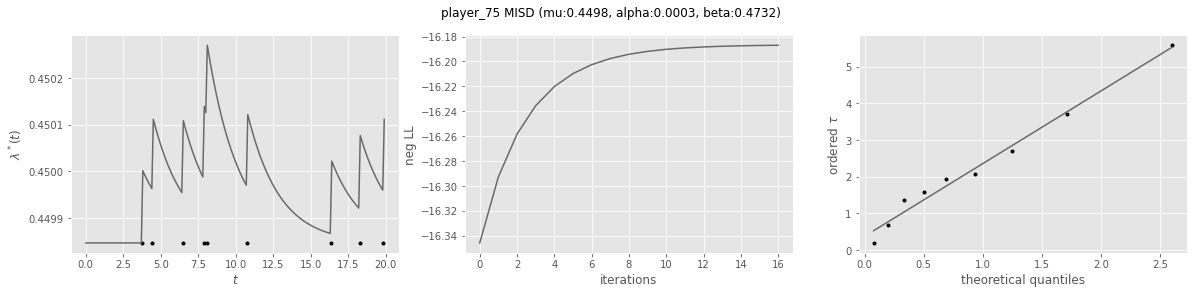

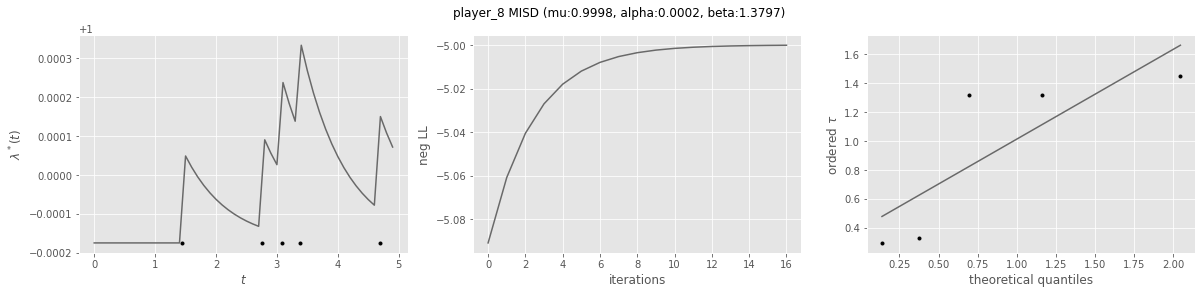

In [89]:
mu,alpha,beta,p_mat = assess_players_misd(players_more_5_injuries)

In [342]:
#max(mu) #1.3332767272278387
#max(alpha) #0.48302216192020153
#max(beta) #9.534172143675525
players_valid_est = ['Player 10','Player 12','Player 13','Player 16','Player 18','Player 19',
           'Player 2','Player 21','Player 22','Player 23','Player 24','Player 25','Player 27',
           'Player 28','Player 32','Player 34',
           'Player 38','Player 39','Player 40','Player 41',
           'Player 42','Player 44','Player 47','Player 48','Player 49',
           'Player 50','Player 52','Player 54','Player 56','Player 57','Player 58','Player 59',
           'Player 6', 'Player 60','Player 62','Player 63','Player 64','Player 65','Player 66',
           'Player 67','Player 68','Player 69', 'Player 72','Player 7','Player 70','Player 73',
           'Player 75','Player 8']
players_err_est = ['Player 15','Player 17','Player 20','Player 29','Player 3','Player 30','Player 31',
                    'Player 35','Player 4','Player 43','Player 45','Player 46','Player 53','Player 61',
                    'Player 71']
#len(players_more_5_injuries) #63
#len(players_valid_est) #48
#len(players_err_est) 15
#len(players_valid_est)/len(players_more_5_injuries) #0.7619047619047619

Player 10 estimating ....
max time41
[ 5.09250703  5.7824596   5.88102425 11.63062897 15.21181133 18.82584858
 22.83414444 23.88550073 24.83829237 26.2181975  27.40097333 29.47083102
 35.25329062 36.17322738 38.96589252 40.47721719]


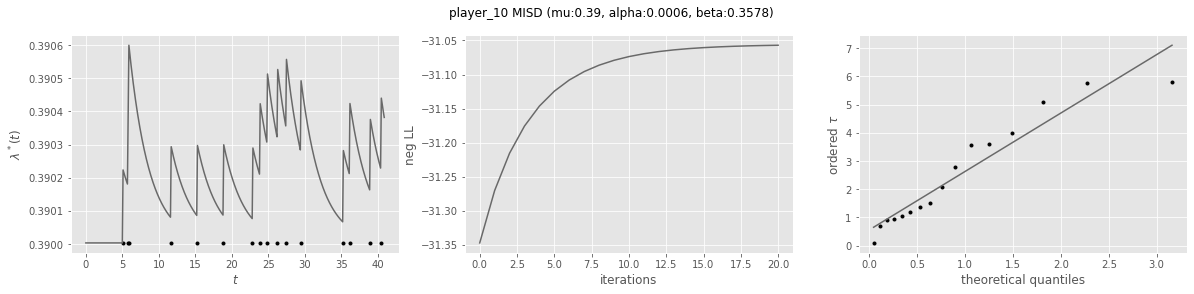

Player 12 estimating ....
max time33
[ 0.26283907  1.4456149   2.29984189  3.48261771  9.95502988 11.7620485
 12.32058153 12.55056572 13.0105341  13.66763178 16.9202653  18.49729974
 20.6328672  23.98406538 24.50974353 25.16684121 25.3968254  25.62680959
 26.31676215 26.74387564 28.55089427 28.78087846 32.65775478]


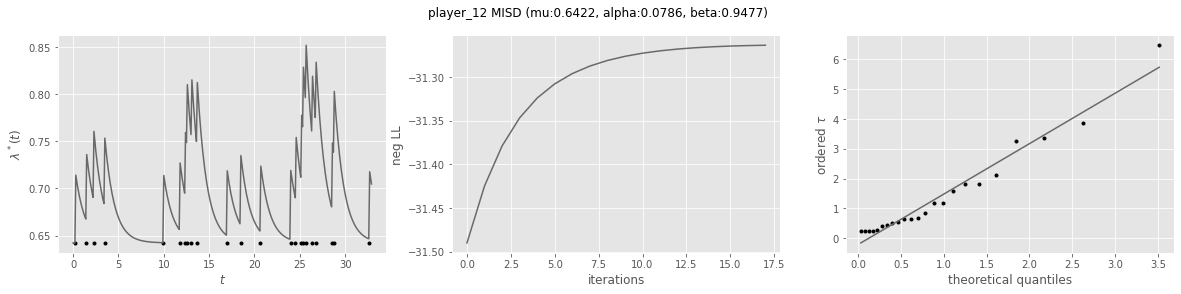

Player 13 estimating ....
max time55
[ 7.88517218  9.03509312  9.95502988 11.66348385 14.88326249 15.9017639
 16.36173227 16.59171646 17.70878252 21.48709419 24.31261422 24.41117887
 25.06827656 26.25105238 28.32091008 30.1279287  35.38471016 36.10751761
 37.91453623 39.2287316  40.247233   45.8325633  48.00098565 49.64372985
 50.82650568 51.74644243 52.436395   52.92921826 53.29062198 53.61917082
 54.5062527 ]


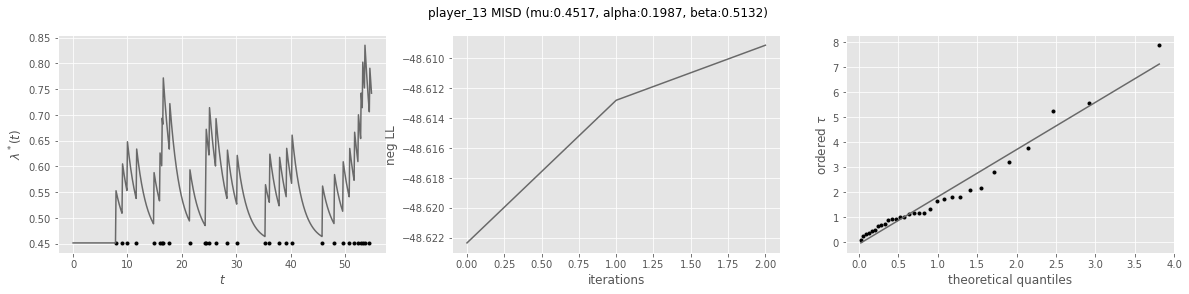

Player 16 estimating ....
max time23
[ 7.62233311 10.57927268 11.07209594 11.7620485  11.99203269 12.41914618
 13.10909875 21.78278815 22.0784821 ]


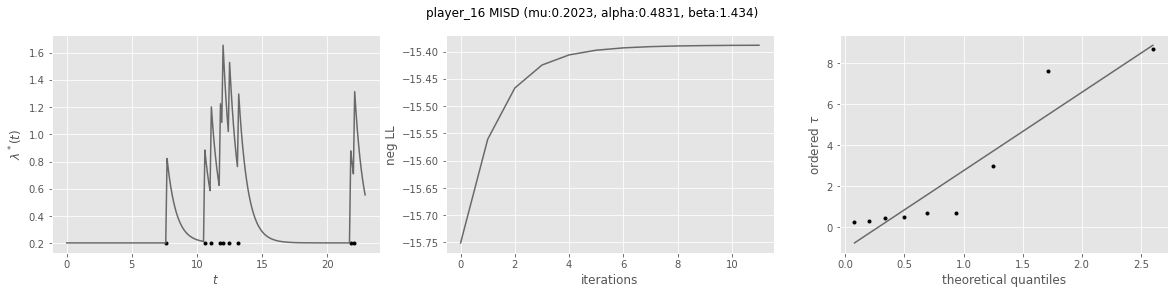

Player 18 estimating ....
max time37
[ 0.59138791  2.10271258  5.58533029  7.81946241  8.27943079  8.77225405
  9.65933592 10.44785314 11.72919362 16.46029693 21.15854535 21.32281977
 21.61851373 22.11133699 24.08263003 24.83829237 25.75822912 28.35376496
 29.1094273  30.09507382 32.88773897 34.03765991 34.43191852 34.72761248
 34.8918869  36.79747017 36.96174459]


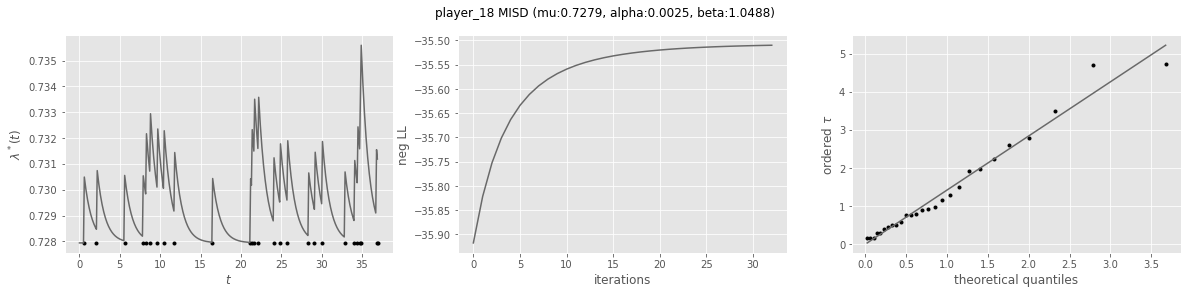

Player 19 estimating ....
max time21
[ 1.74130886  2.36555165  2.92408468  3.38405306  7.75375264  8.21372102
 11.26922524 11.5649192  13.56906713 14.25901969 15.50750529 16.03318343
 16.723136   18.33302532 19.05583277 19.71293045 20.14004394 20.89570628]


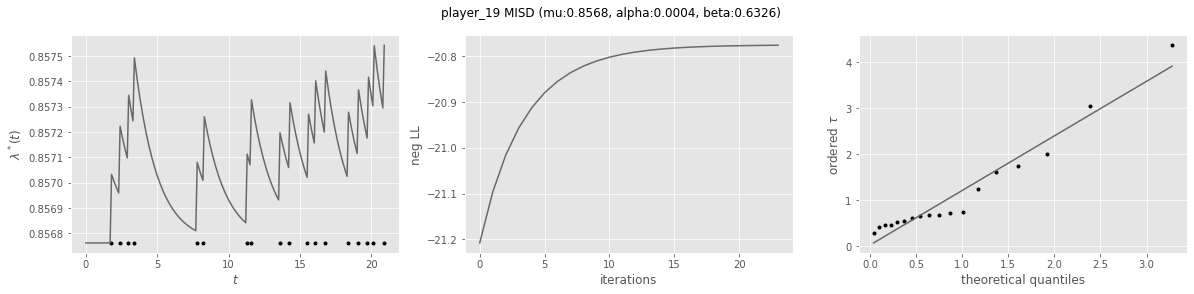

Player 2 estimating ....
max time57
[ 0.6242428   4.66539354  5.81531448 11.20351547 12.05774246 13.37193782
 15.24466621 15.67177971 15.86890901 17.28166903 17.77449229 18.00447648
 19.12154254 23.22840305 24.1483398  25.82393889 26.74387564 27.63095751
 28.12378078 28.55089427 28.97800776 30.42362266 34.82617713 38.57163391
 39.82011951 41.85712232 42.28423582 43.26988234 52.92921826 55.39333457
 55.55760899 56.08328713]


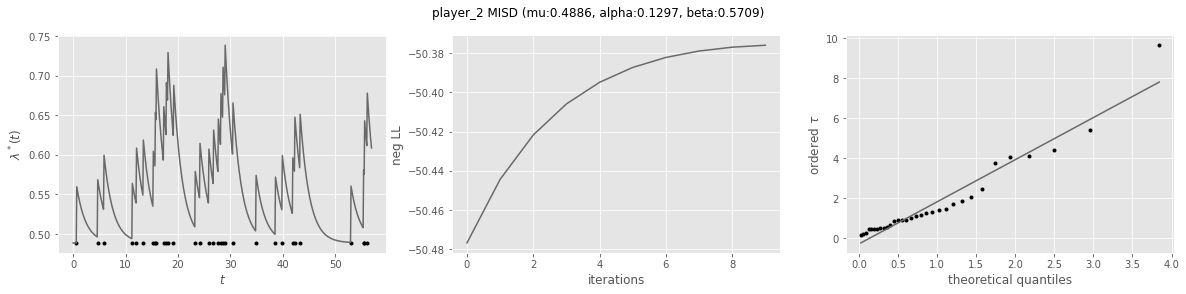

Player 21 estimating ....
max time53
[ 1.97129305  9.00223824 11.23637036 15.17895645 20.79714163 23.65551654
 25.03542167 27.59810263 34.69475759 36.76461529 39.55728044 40.41150742
 42.80991396 45.24117538 48.9209224  49.24947124 51.02363498 52.04213639]


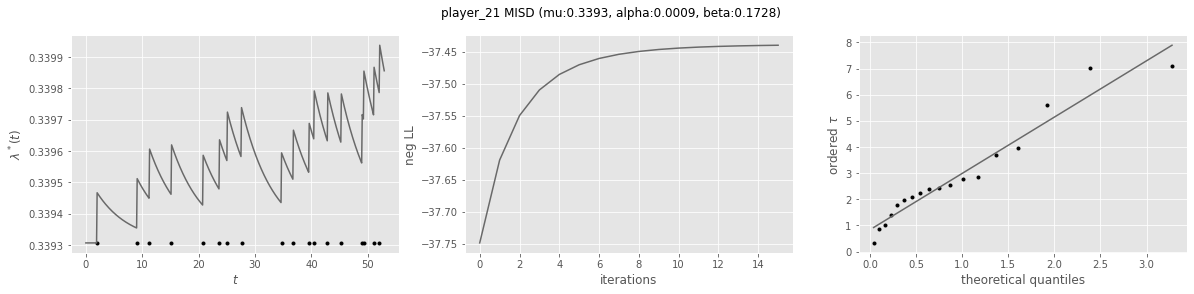

Player 22 estimating ....
max time30
[ 1.18277583  2.59553584  3.77831167  6.99809031 17.47879833 18.07018625
 21.84849792 24.08263003 29.96365428]


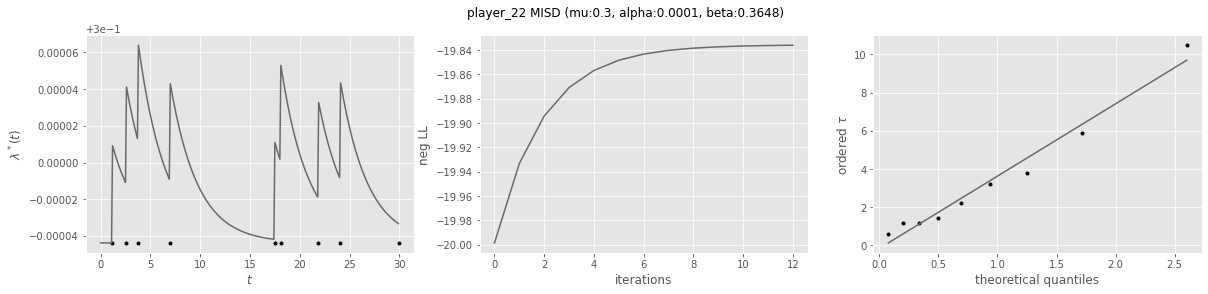

Player 23 estimating ....
max time52
[ 1.60988932  2.0698577   6.73525124  8.96938335  9.19936754 11.99203269
 13.33908294 21.81564303 22.76843467 26.94100495 34.20193433 34.92474178
 36.96174459 37.48742274 38.90018276 44.5840777  50.169408   50.85936056
 51.54931313]


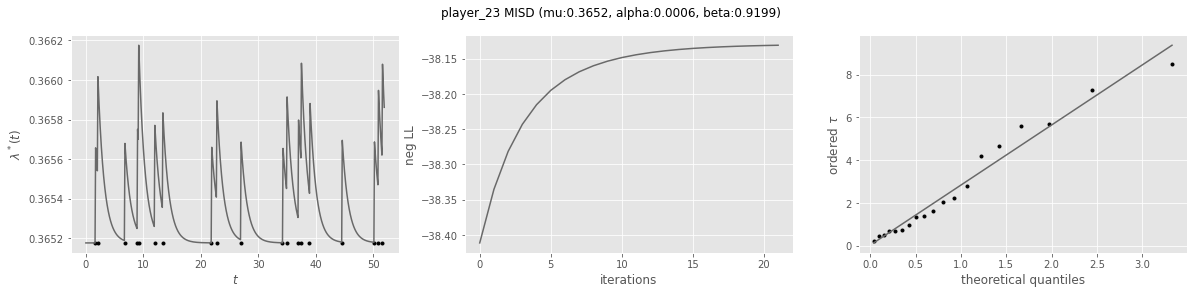

Player 24 estimating ....
max time57
[ 4.00829586  4.69824842  4.99394238  5.55247541  5.84816937  6.47241216
 10.80925686 12.02488757 12.35343642 13.86476108 14.16045504 15.08039179
 16.42744204 16.82170065 17.57736298 17.84020206 18.95726812 22.7027249
 24.44403376 26.48103657 29.3065566  30.22649336 31.40926918 36.50177622
 37.22458367 40.70720138 43.49986653 52.17355593 54.86765642 55.09764061
 55.39333457 56.44469086]
Player 24 has convergence issues, no valid estimate.
Player 25 estimating ....
max time46
[ 1.28134048  2.98979445  7.98373683  8.54226986  9.10080289 11.33493501
 12.41914618 14.0290355  14.42329411 14.68613319 16.06603832 16.49315181
 16.95312019 17.44594345 17.67592764 17.87305694 18.7929937  20.6328672
 20.89570628 21.15854535 21.28996489 23.91835561 26.57960122 28.22234543
 28.68231381 30.09507382 30.52218731 30.98215569 31.24499476 31.47497895
 31.93494733 32.98630362 33.24914269 35.48327481 37.02745436 37.09316413
 37.71740693 38.17737531 39.2287316  42.941333

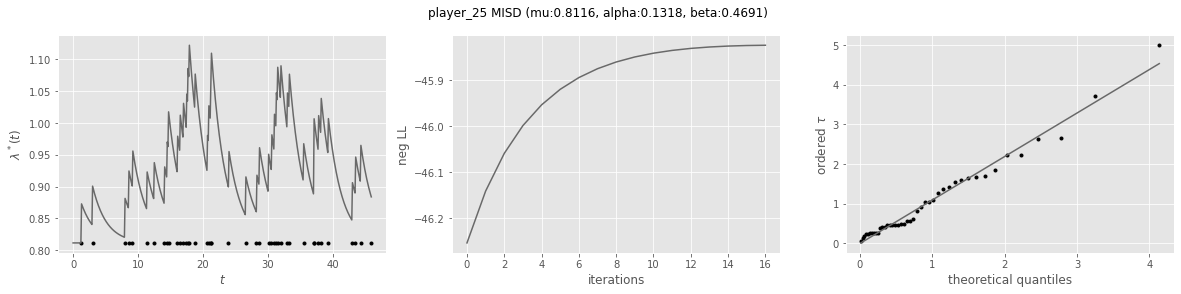

Player 27 estimating ....
max time51
[ 9.19936754 12.41914618 13.33908294 16.26316762 20.69857697 22.30846629
 22.93270909 25.19969609 34.23478922 34.72761248 35.81182365 37.61884228
 40.0501037  44.15696421 48.49380891 50.56366661]


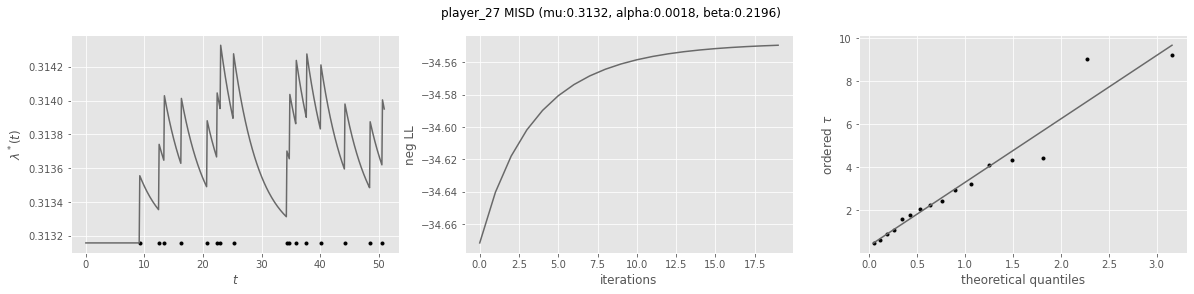

Player 28 estimating ....
max time34
[ 0.65709768  2.66124561  3.41690794  3.5154726   4.23828005  4.73110331
  5.1582168   6.53812193  7.16236473  7.55662334  8.64083451 11.5649192
 12.81340479 13.96332574 14.32472946 16.65742623 17.61021787 18.39873509
 19.64722068 23.16269328 23.29411282 25.29826074 26.77673053 28.58374915
 29.40512126 30.22649336 30.52218731 31.40926918 31.50783384 32.92059385
 33.34770735]


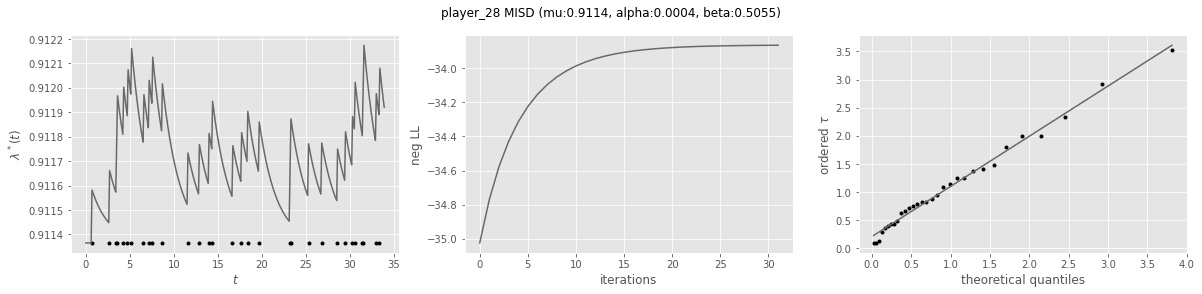

Player 32 estimating ....
max time15
[ 2.75981026 11.7620485  11.95917781 14.48900388 14.94897226]


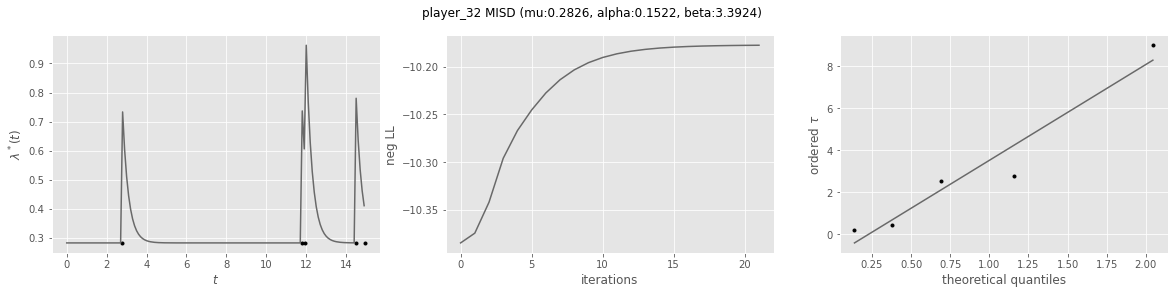

Player 34 estimating ....
max time57
[ 4.50111912  5.1582168   6.11100844  6.53812193  6.80096101  7.8523173
 12.64913037 13.43764759 14.39043923 16.46029693 19.1872523  22.24275652
 27.00671472 27.69666728 29.04371753 30.02936405 30.16078359 31.83638268
 32.29635105 32.52633524 36.27179203 38.73590833 39.88582928 40.60863673
 40.83862092 41.20002464 42.21852605 42.41565535 49.47945543 49.77514939
 52.04213639 53.81630013 54.40768804 55.45904433 55.91901271 56.1489969
 56.67467504]


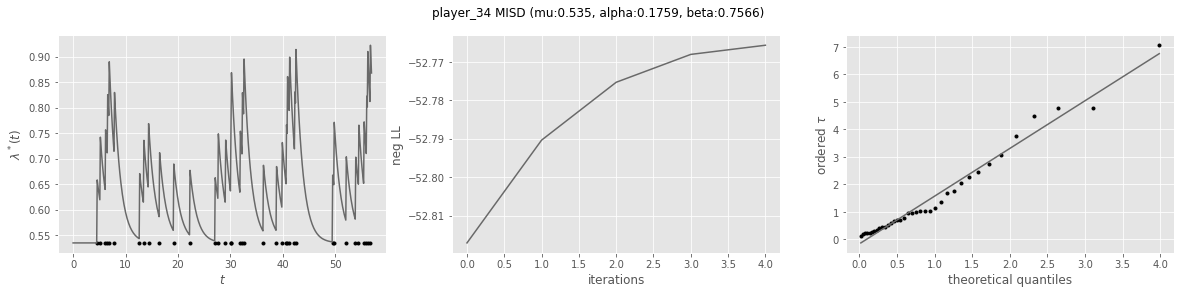

Player 38 estimating ....
max time10
[1.37990513 3.84402144 4.30398981 5.68389495 7.75375264 8.70654428
 9.16651266]


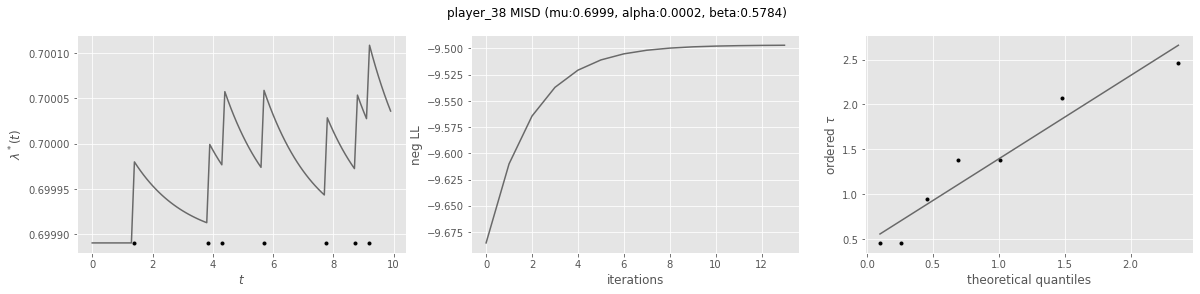

Player 39 estimating ....
max time46
[ 1.4456149   1.90558328  7.72089776 11.63062897 13.33908294 14.6532783
 14.81755272 15.34323087 16.23031274 17.44594345 18.33302532 19.02297788
 19.12154254 25.42968028 26.2181975  27.53239286 30.16078359 31.21213988
 31.44212407 32.59204501 36.23893714 37.1588739  38.17737531 39.06445718
 39.49157067 40.18152323 41.82426744 42.71134931 43.86127025 45.04404608]


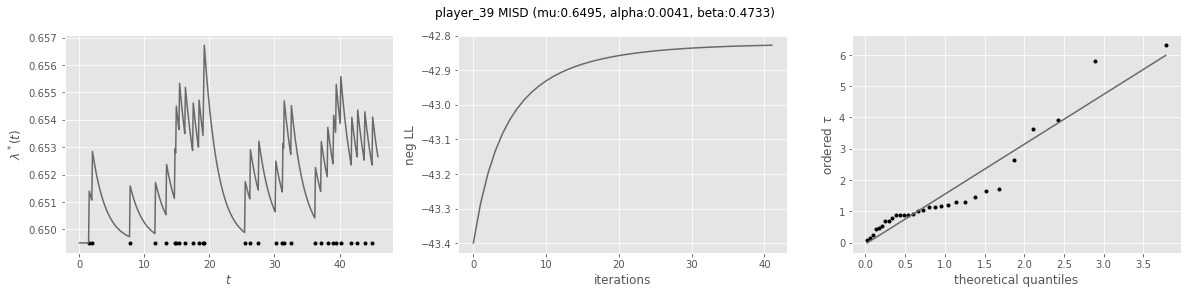

Player 40 estimating ....
max time43
[ 2.62839073  3.12121399  4.56682889  8.73939917 19.28581696 23.45838724
 23.91835561 24.1483398  27.99236124 28.4851845  30.52218731 30.78502639
 31.01501058 31.24499476 31.90209245 32.16493152 32.8220292  33.28199758
 33.51198177 39.72155486 42.90847861]


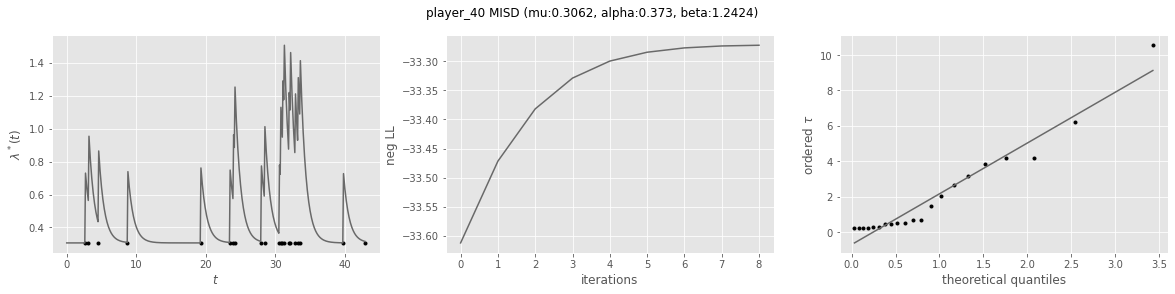

Player 41 estimating ....
max time57
[ 4.92823261  8.14801125  8.93652847 13.56906713 16.19745785 16.9202653
 17.11739461 18.95726812 20.14004394 20.37002813 21.0599807  25.82393889
 28.18949054 29.1094273  30.22649336 31.14643011 32.09922175 38.17737531
 39.16302183 39.88582928 40.11581347 40.57578184 41.26573441 43.33559211
 44.25552886 44.94548143 51.38503871 56.01757736 56.21470667 56.47754574]


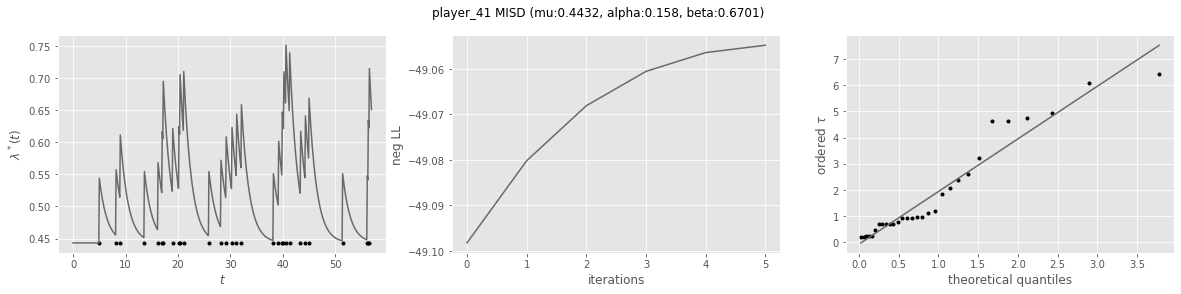

Player 42 estimating ....
max time33
[ 0.85422699  1.67559909  1.90558328  2.20127723  2.82552003  5.05965215
  5.25678145  6.01244379  6.47241216  6.93238054  7.19521961  7.4252038
  7.58947822 10.21786895 10.90782152 11.82775827 13.10909875 13.56906713
 14.75184295 15.4746504  15.80319924 15.9017639  16.0988932  17.21595926
 17.74163741 22.40703095 23.78693608 24.83829237 28.74802357 29.01086265
 29.24084683 29.70081521 30.19363847 30.71931662 30.88359104 31.80352779
 31.93494733 32.16493152 32.36206082]


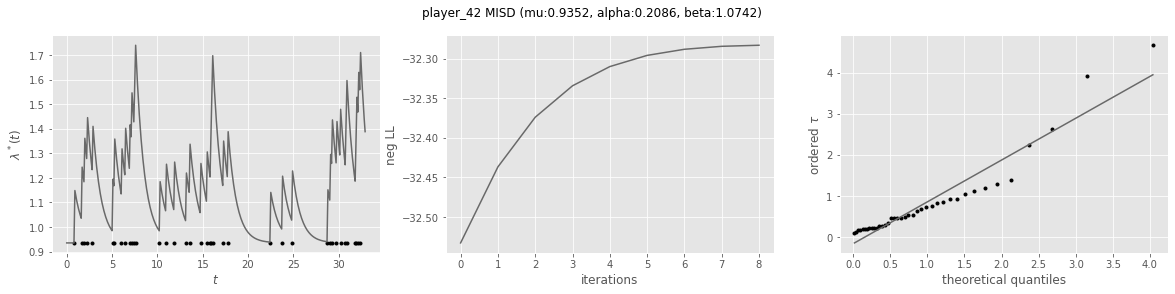

Player 44 estimating ....
max time27
[ 0.22998419  2.29984189  7.19521961 10.34928849 12.87911456 22.20990164
 24.1483398  24.60830818 26.2181975 ]


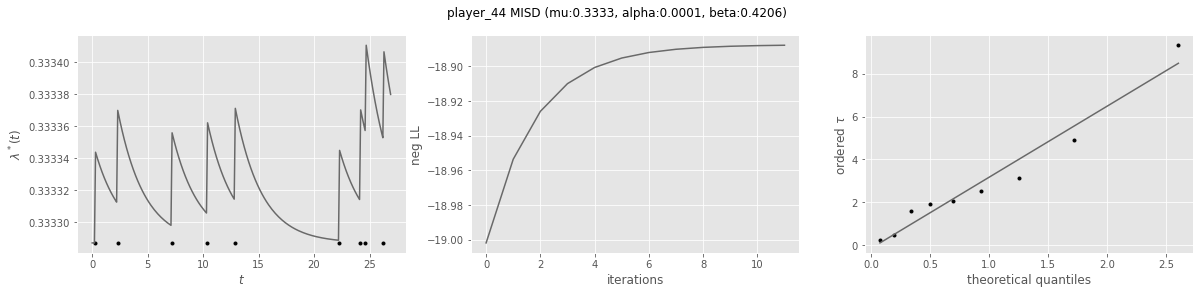

Player 47 estimating ....
max time55
[ 9.92217499 11.92632292 12.32058153 13.10909875 13.53621224 14.456149
 15.50750529 18.82584858 24.60830818 26.64531099 27.33526356 28.25520031
 29.43797614 29.63510544 31.01501058 35.05616132 35.51612969 38.6044888
 39.06445718 40.21437812 41.85712232 45.01119119 48.69093821 54.5062527 ]


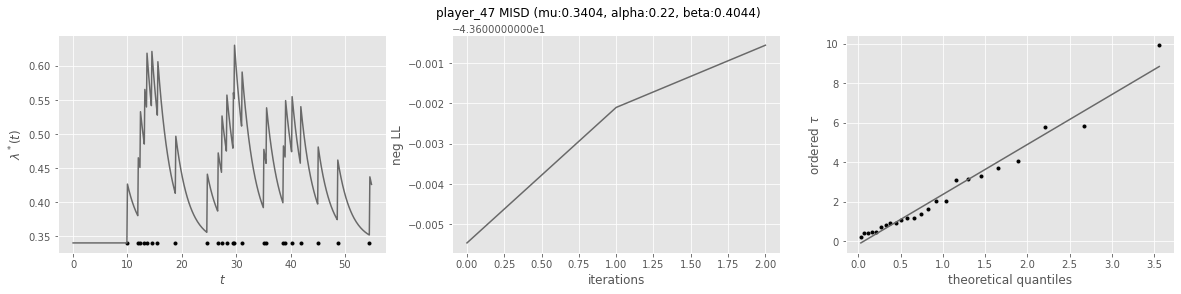

Player 48 estimating ....
max time26
[ 1.97129305  4.86252284  6.76810612  8.18086614  8.70654428  8.93652847
 10.05359453 10.77640198 12.97767921 13.99618062 14.22616481 16.59171646
 18.66157416 19.54865603 22.96556397 23.35982258 25.29826074]


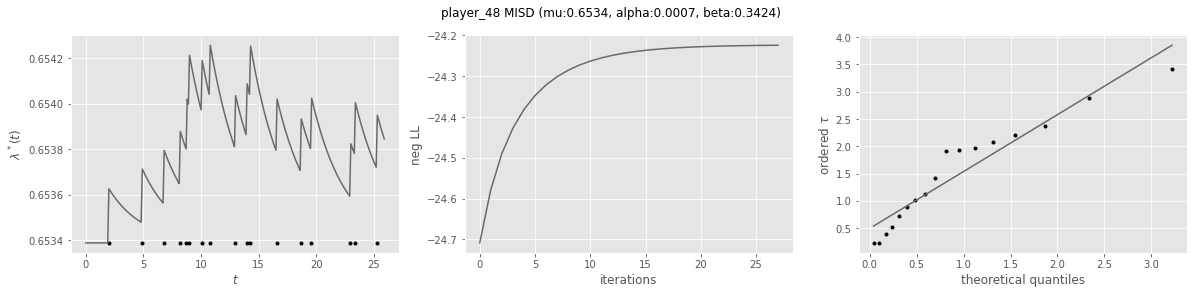

Player 49 estimating ....
max time12
[ 0.88708187  2.10271258  2.20127723  9.16651266 10.08644941 11.00638617
 11.82775827]


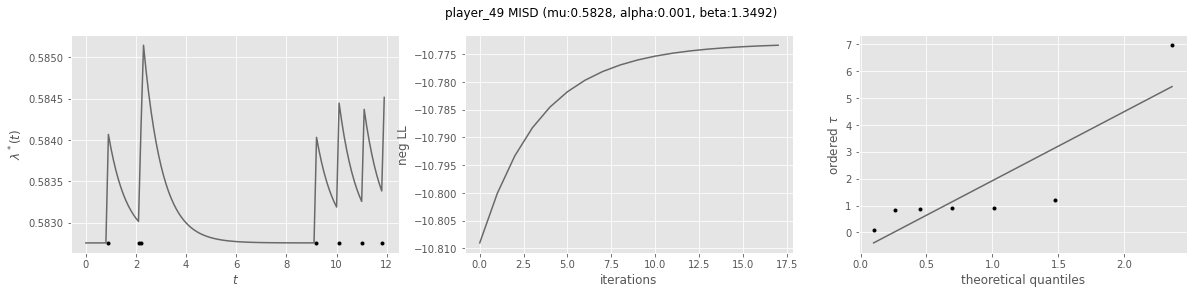

Player 50 estimating ....
max time44
[ 5.61818518  7.32663915 12.12345223 12.94482433 13.89761597 15.96747366
 16.95312019 24.08263003 25.10113144 26.51389146 28.15663566 28.68231381
 31.63925337 34.8918869  37.02745436 38.50592415 40.60863673 41.72570279
 42.87562373 43.82841537]


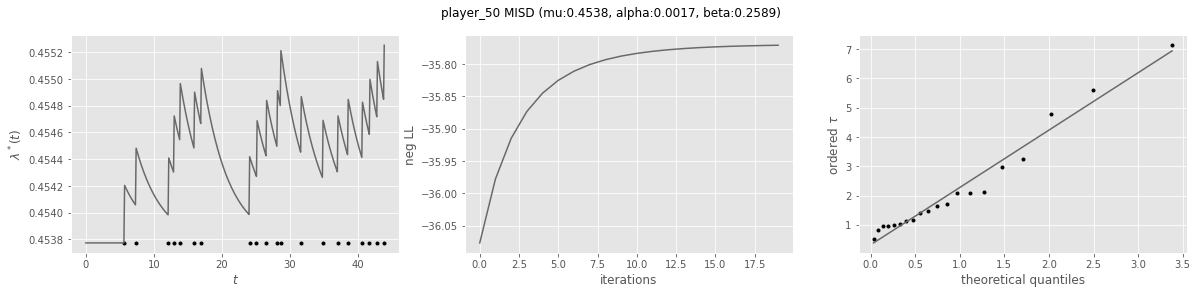

Player 52 estimating ....
max time44
[ 1.80701862  2.36555165  2.79266515  3.90973121  4.92823261  5.55247541
  6.4067024   7.4252038   7.68804288 12.189162   12.51771084 13.63477689
 15.4746504  18.23446067 18.89155835 19.38438161 20.10718906 29.47083102
 31.5735436  37.25743855 37.94739112 40.97004045 42.38280047 43.07275303]


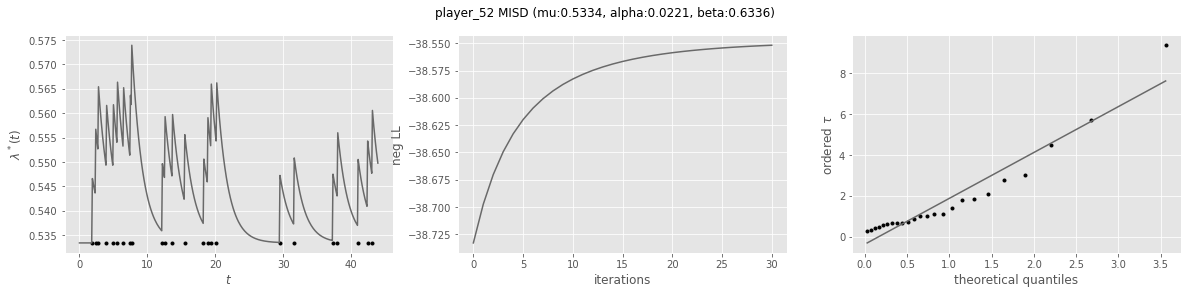

Player 54 estimating ....
max time30
[ 2.03700281  2.33269677  3.25263352  3.48261771  3.74545679  4.40255447
  4.86252284  8.14801125 10.90782152 11.49920943 12.68198526 13.8319062
 14.29187458 15.67177971 16.62457135 16.85455554 17.08453972 20.82999651
 22.7027249  23.1298384  23.45838724 24.18119469 26.94100495 27.17098914
 27.63095751 28.12378078 28.35376496 29.04371753 29.27370172 29.86508963]


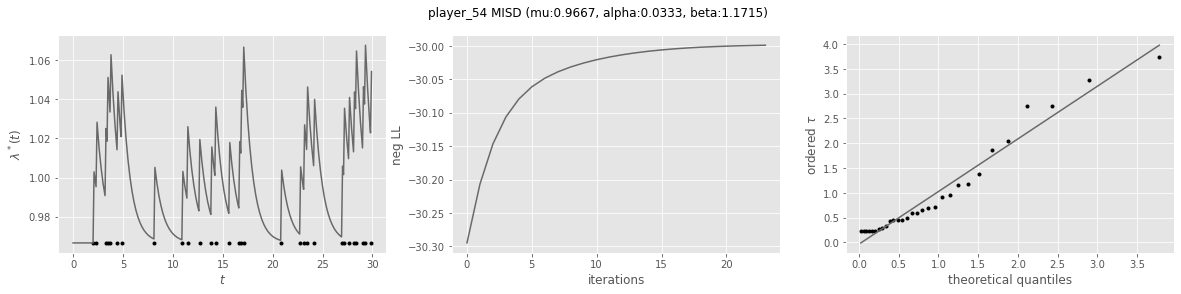

Player 56 estimating ....
max time8
[1.05135629 2.69410049 2.92408468 7.06380008 7.26092938]


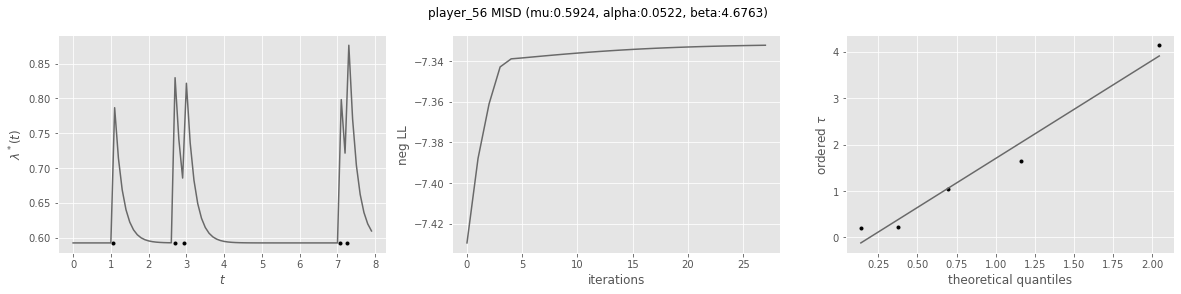

Player 57 estimating ....
max time6
[0.22998419 2.39840654 3.74545679 3.94258609 4.63253866 5.35534611]


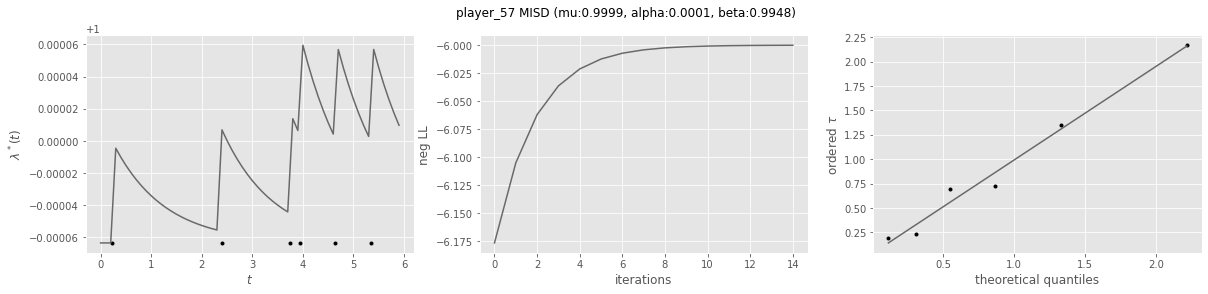

Player 58 estimating ....
max time8
[0.06570977 1.37990513 4.56682889 5.22392657 7.06380008 7.52376846]


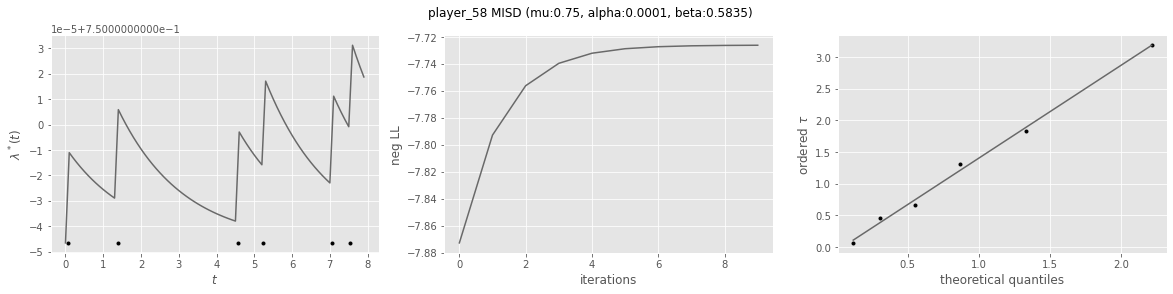

Player 59 estimating ....
max time15
[ 1.18277583  3.21977864  3.31834329 10.21786895 11.07209594 11.99203269
 14.25901969]


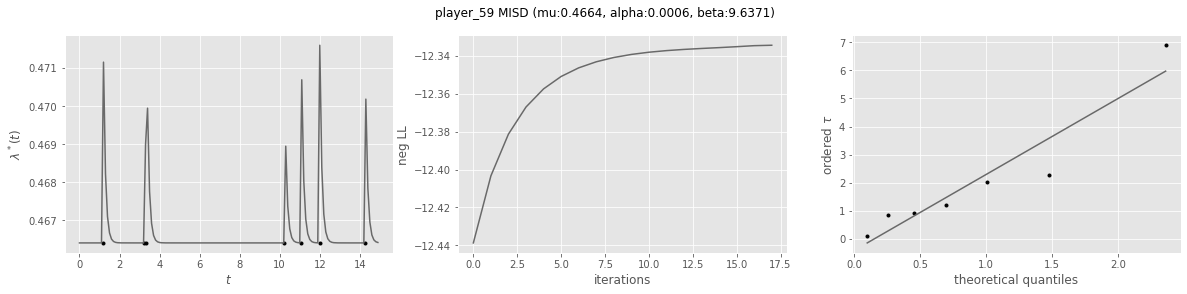

Player 6 estimating ....
max time25
[ 1.41276002  5.02679726  5.35534611  8.21372102  8.50941498  8.93652847
  9.42935173 10.61212756 11.7620485  12.41914618 12.74769502 12.84625968
 13.37193782 16.39458716 24.37832399]


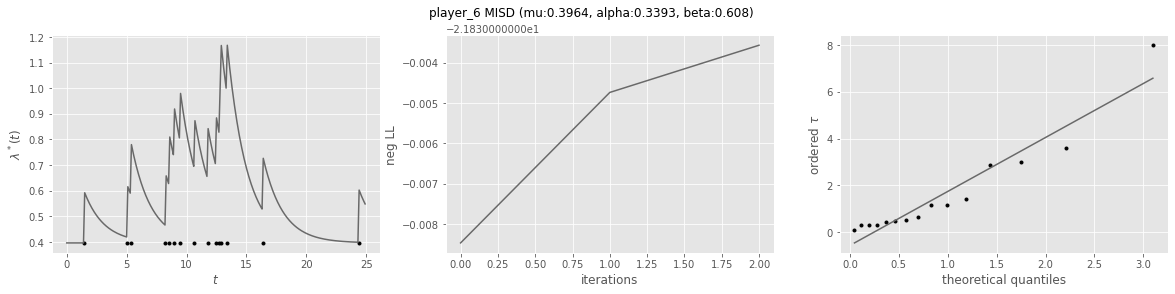

Player 60 estimating ....
max time9
[1.54417955 3.87687632 6.47241216 7.4252038  8.77225405]


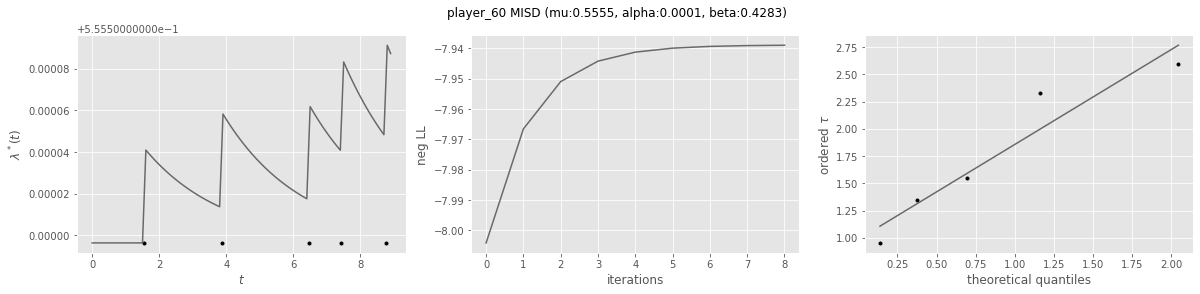

Player 62 estimating ....
max time55
[14.81755272 15.70463459 17.11739461 17.5445081  23.524097   23.98406538
 25.36397051 26.05392308 26.97385983 28.61660404 29.43797614 30.88359104
 33.31485246 35.9103883  37.32314832 38.24308507 38.96589252 41.6928479
 47.2781782  47.63958192 48.00098565 52.27212058 54.76909177]


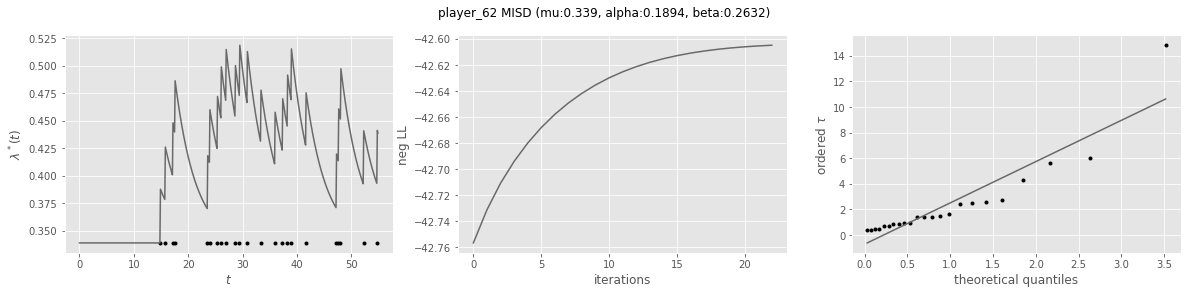

Player 63 estimating ....
max time14
[ 0.98564652  1.57703444  2.0698577   2.266987    7.91802706 10.25072383
 11.00638617 11.49920943 12.84625968 13.76619643]


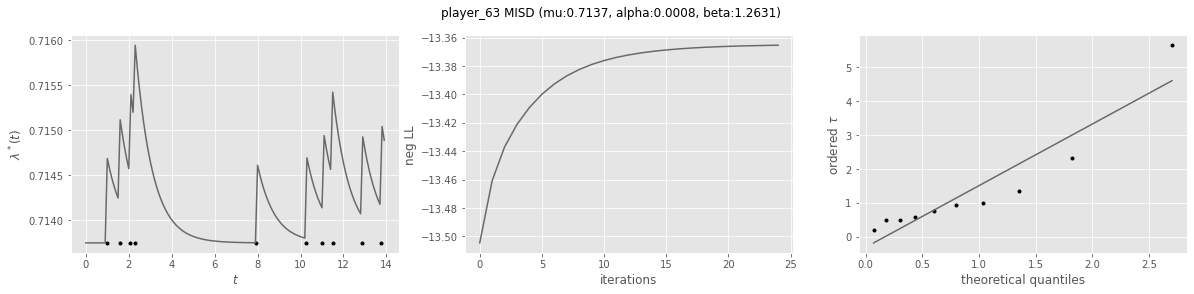

Player 64 estimating ....
max time20
[ 4.533974    5.68389495  5.91387914 11.03924105 18.72728393 19.25296207]


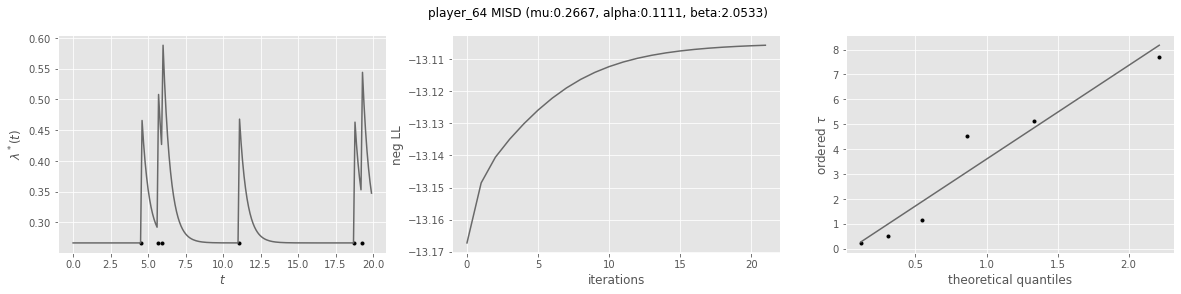

Player 65 estimating ....
max time18
[ 0.68995257  2.82552003  3.21977864 10.18501407 10.71069221 11.49920943
 12.87911456 13.33908294 15.17895645 15.40894064 16.32887739 17.47879833]


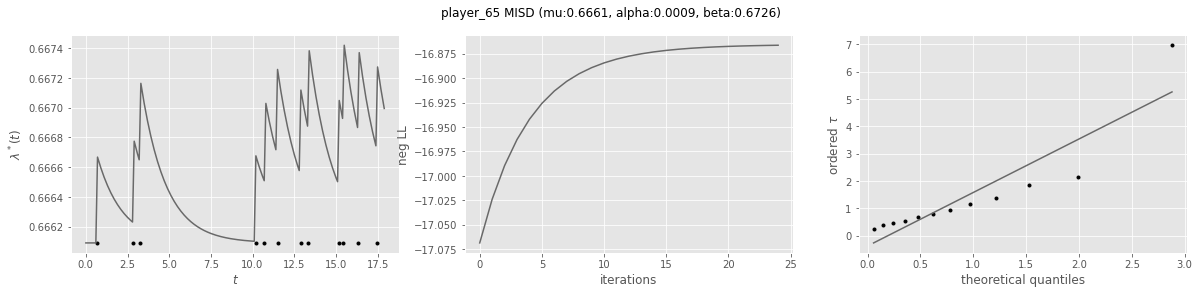

Player 66 estimating ....
max time54
[ 1.14992094  2.266987    6.76810612  9.13365778  9.23222243 10.3164336
 10.48070802 11.69633873 13.76619643 13.99618062 14.456149   15.50750529
 16.26316762 19.35152673 20.40288302 21.74993326 22.0784821  24.11548492
 24.60830818 25.46253516 27.59810263 28.25520031 30.85073615 31.44212407
 32.46062547 34.16907945 34.92474178 35.31900039 35.87753342 36.30464691
 37.25743855 37.68455204 38.34164973 39.49157067 39.78726463 44.94548143
 45.89827307 49.01948705 49.5451652  50.10369823 51.02363498 52.76494384
 53.09349268]


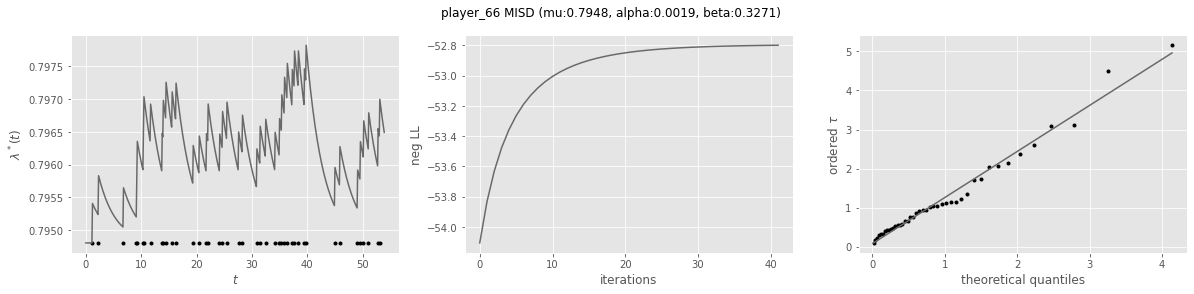

Player 67 estimating ....
max time59
[ 3.58118237  8.77225405 11.82775827 14.35758434 15.31037598 15.9017639
 16.06603832 16.59171646 18.00447648 19.35152673 20.56715744 21.8813528
 25.49539005 26.67816588 30.39076778 32.95344874 33.18343292 33.90624037
 36.56748599 36.79747017 40.28008789 40.83862092 42.44851024 43.03989815
 44.68264235 45.76685353 47.93527588 48.2966796  54.04628432 54.5062527
 54.76909177 55.22906014 55.45904433 56.37898109 57.23320807 57.39748249
 58.44883879]


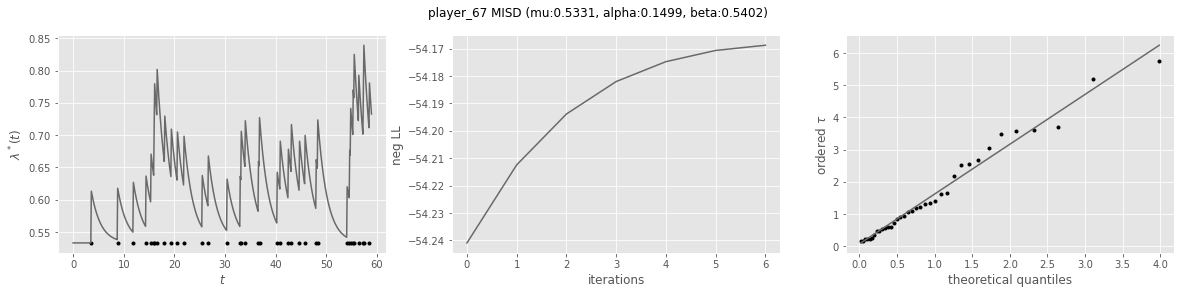

Player 68 estimating ....
max time6
[0.1971293  1.47846978 1.57703444 1.93843816 3.05550422 4.69824842
 5.1582168  5.84816937]


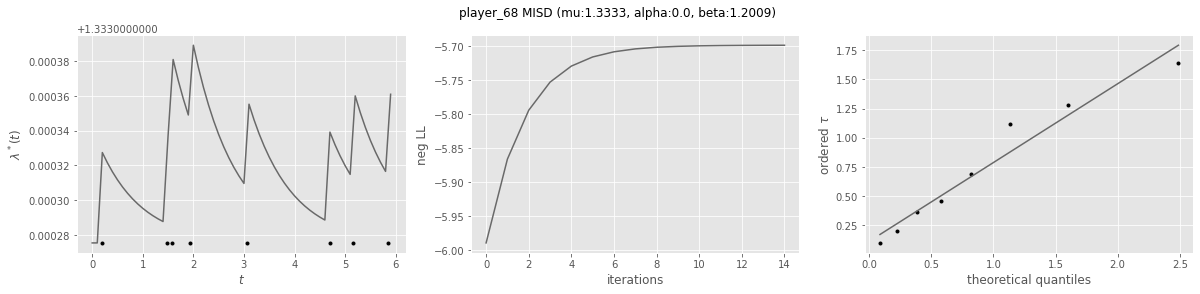

Player 69 estimating ....
max time9
[2.00414793 4.63253866 5.12536192 5.74960471 7.16236473 8.34514056]


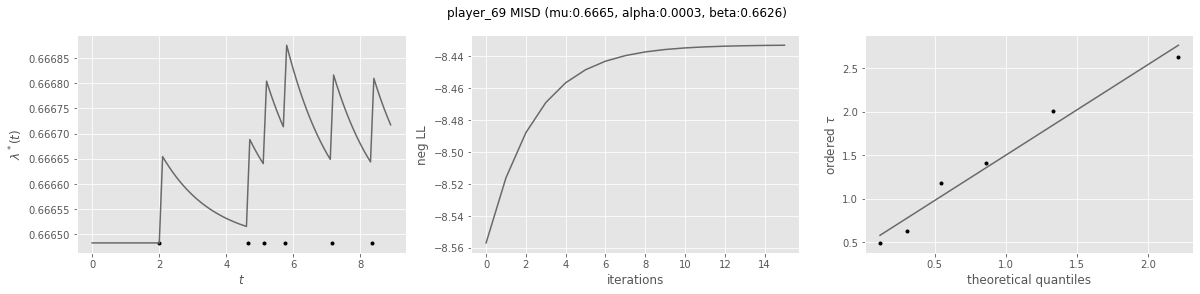

Player 72 estimating ....
max time39
[ 1.14992094  2.52982607  3.21977864  4.04115074  9.06794801  9.62648104
 13.47050247 13.76619643 14.94897226 16.00032855 18.56300951 19.71293045
 20.40288302 21.58565884 21.84849792 24.34546911 24.57545329 25.49539005
 25.95535843 26.2181975  27.13813425 31.14643011 33.74196595 35.05616132
 35.38471016 36.30464691 36.76461529 37.52027762 37.91453623 38.40735949]


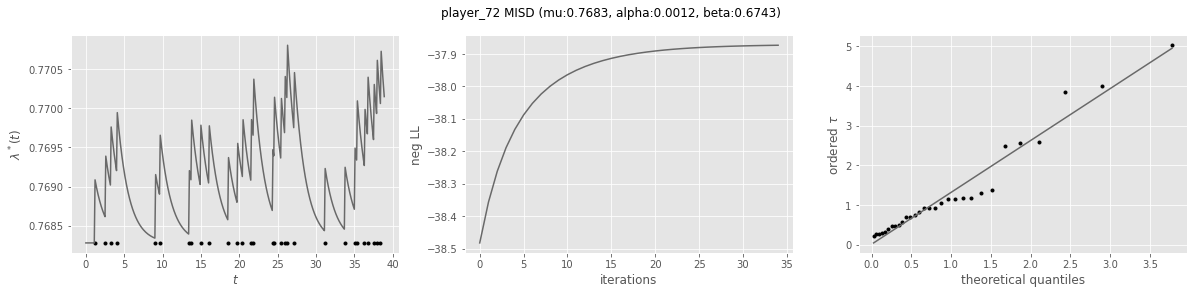

Player 7 estimating ....
max time35
[ 2.95693957  7.52376846  8.21372102 12.09059734 12.64913037 13.56906713
 14.39043923 16.26316762 17.18310438 19.25296207 19.94291464 20.17289883
 20.89570628 27.23669891 27.79523193 29.33941149 31.70496314 33.15057804
 33.31485246 34.20193433]


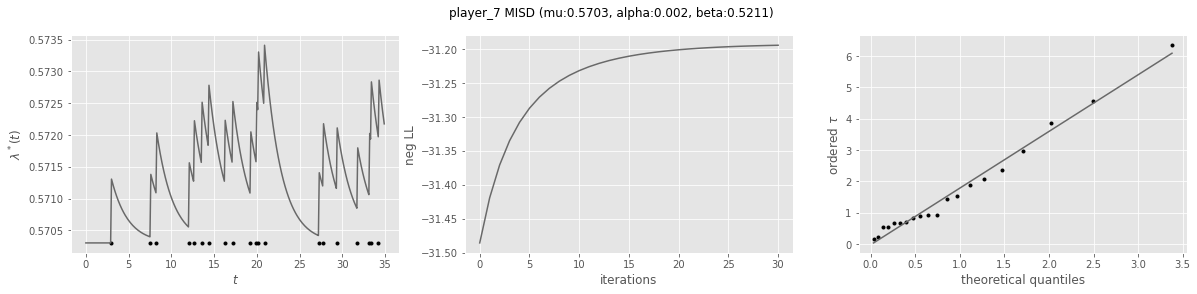

Player 70 estimating ....
max time17
[ 3.12121399  3.58118237  4.73110331  8.47656009  9.62648104  9.85646523
 11.89346804 12.78054991 16.00032855 16.9202653 ]


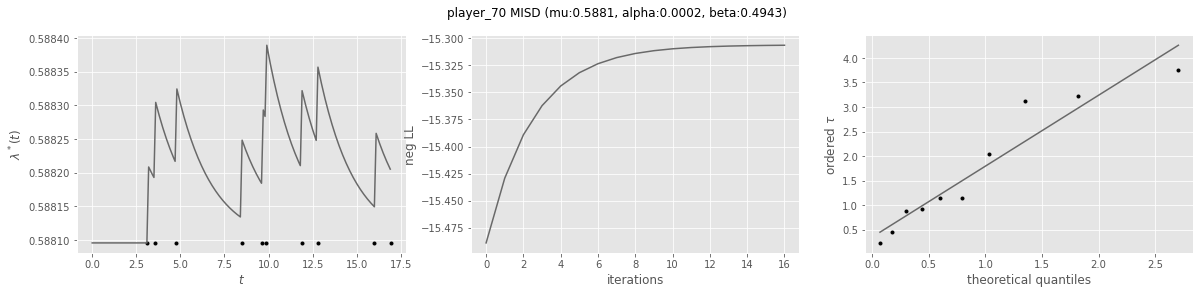

Player 73 estimating ....
max time33
[ 0.6242428   2.00414793  5.38820099  5.91387914  7.68804288 13.17480852
 14.29187458 15.08039179 16.42744204 17.80734717 18.990123   19.68007557
 20.10718906 20.50144767 20.60001232 21.02712581 21.48709419 24.21404957
 25.06827656 25.29826074 27.0395696  27.30240867 29.27370172 29.53654079
 30.91644592 31.86923756 32.09922175]


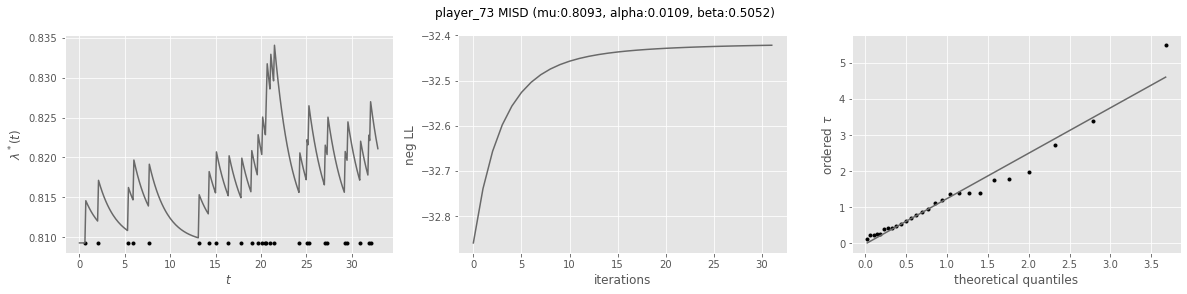

Player 75 estimating ....
max time20
[ 3.7126019   4.40255447  6.47241216  7.8523173   8.0494466  10.7435471
 16.32887739 18.26731555 19.84434999]


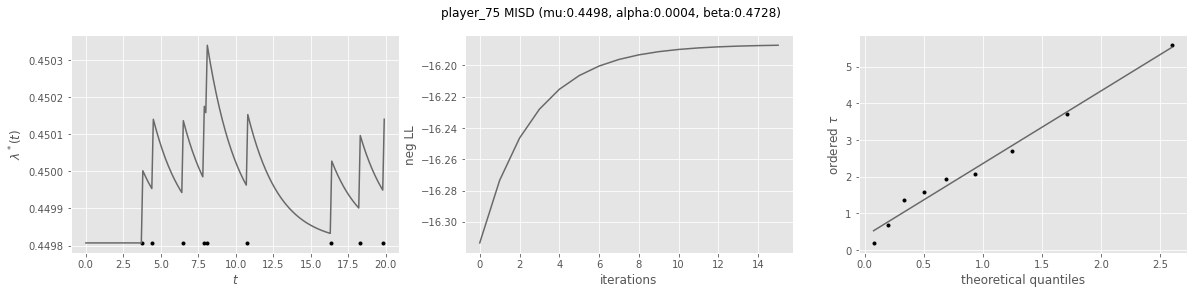

Player 8 estimating ....
max time5
[1.4456149  2.75981026 3.0883591  3.38405306 4.69824842]


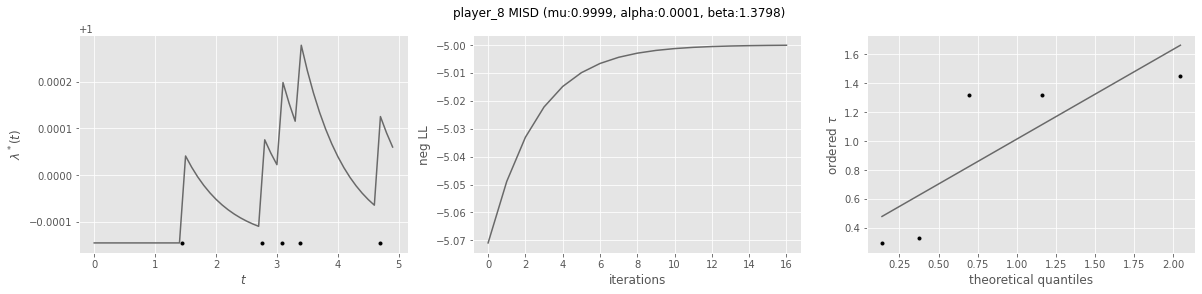

In [343]:
#valid parameters estimates
mu_lst,alpha_lst,beta_lst,p_matrix,neg_ll_lst,player_valid_est,player_err_est,smp_all = \
assess_players_misd(players_valid_est, True,False)

In [344]:
#diagonal mass
diagonal_mass_info(p_matrix,smp_all,mu_lst,player_valid_est,tol = 2)

Player & Diagonal Mass & Background Rate & No. of offspring & Number of 2 months Offspring  & Per. of Offspring in first 2 Months \\ 
Player 10 & 99.95\% & 0.39 & 0 & 0 & 0\% \\ 
Player 12 & 92.42\% & 0.6422 & 0.087 & 0.0435 & 50.0\% \\ 
Player 13 & 81.76\% & 0.4517 & 0.2258 & 0.129 & 57.14\% \\ 
Player 16 & 51.67\% & 0.2023 & 0.6667 & 0.6667 & 100.0\% \\ 
Player 18 & 99.78\% & 0.7279 & 0 & 0 & 0\% \\ 
Player 19 & 99.97\% & 0.8568 & 0 & 0 & 0\% \\ 
Player 2 & 87.68\% & 0.4886 & 0.125 & 0.0938 & 75.0\% \\ 
Player 21 & 99.93\% & 0.3393 & 0 & 0 & 0\% \\ 
Player 22 & 99.99\% & 0.3 & 0 & 0 & 0\% \\ 
Player 23 & 99.95\% & 0.3652 & 0 & 0 & 0\% \\ 
Player 25 & 87.43\% & 0.8116 & 0.1163 & 0.1163 & 100.0\% \\ 
Player 27 & 99.85\% & 0.3132 & 0 & 0 & 0\% \\ 
Player 28 & 99.96\% & 0.9114 & 0 & 0 & 0\% \\ 
Player 32 & 84.77\% & 0.2826 & 0.2 & 0.2 & 100.0\% \\ 
Player 34 & 83.5\% & 0.535 & 0.1081 & 0.1081 & 100.0\% \\ 
Player 38 & 99.99\% & 0.6999 & 0 & 0 & 0\% \\ 
Player 39 & 99.63\% & 0.6495 & 0 & 

In [345]:
diagonal_mass_info(p_matrix,smp_all,mu_lst,player_valid_est,tol = 4)

Player & Diagonal Mass & Background Rate & No. of offspring & Number of 4 months Offspring  & Per. of Offspring in first 4 Months \\ 
Player 10 & 99.95\% & 0.39 & 0 & 0 & 0\% \\ 
Player 12 & 92.42\% & 0.6422 & 0 & 0 & 0\% \\ 
Player 13 & 81.76\% & 0.4517 & 0.2903 & 0.2258 & 77.78\% \\ 
Player 16 & 51.67\% & 0.2023 & 0.4444 & 0.4444 & 100.0\% \\ 
Player 18 & 99.78\% & 0.7279 & 0 & 0 & 0\% \\ 
Player 19 & 99.97\% & 0.8568 & 0 & 0 & 0\% \\ 
Player 2 & 87.68\% & 0.4886 & 0.1875 & 0.1875 & 100.0\% \\ 
Player 21 & 99.93\% & 0.3393 & 0 & 0 & 0\% \\ 
Player 22 & 99.99\% & 0.3 & 0 & 0 & 0\% \\ 
Player 23 & 99.95\% & 0.3652 & 0 & 0 & 0\% \\ 
Player 25 & 87.43\% & 0.8116 & 0.1163 & 0.093 & 80.0\% \\ 
Player 27 & 99.85\% & 0.3132 & 0 & 0 & 0\% \\ 
Player 28 & 99.96\% & 0.9114 & 0 & 0 & 0\% \\ 
Player 32 & 84.77\% & 0.2826 & 0.2 & 0.2 & 100.0\% \\ 
Player 34 & 83.5\% & 0.535 & 0.1892 & 0.1892 & 100.0\% \\ 
Player 38 & 99.99\% & 0.6999 & 0 & 0 & 0\% \\ 
Player 39 & 99.63\% & 0.6495 & 0 & 0 & 0\% \\ 

In [404]:
#extract paramters
mu_est,alpha_est,beta_est,branch_rat = [],[],[],[]
for i in range(len(player_valid_est)):
    mu_est.append(mu_lst[i][-1])
    alpha_est.append(alpha_lst[i][-1])
    beta_est.append(beta_lst[i][-1])
    branch_rat.append(alpha_lst[i][-1]/beta_lst[i][-1])
#assign to dataframe
df_org = pd.DataFrame({'mu':mu_est,'branch-ratio':branch_rat,'alpha':alpha_est, 'beta':beta_est,
                  'player':player_valid_est})

(array([ 0.,  2.,  4.,  6.,  8., 10., 12.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

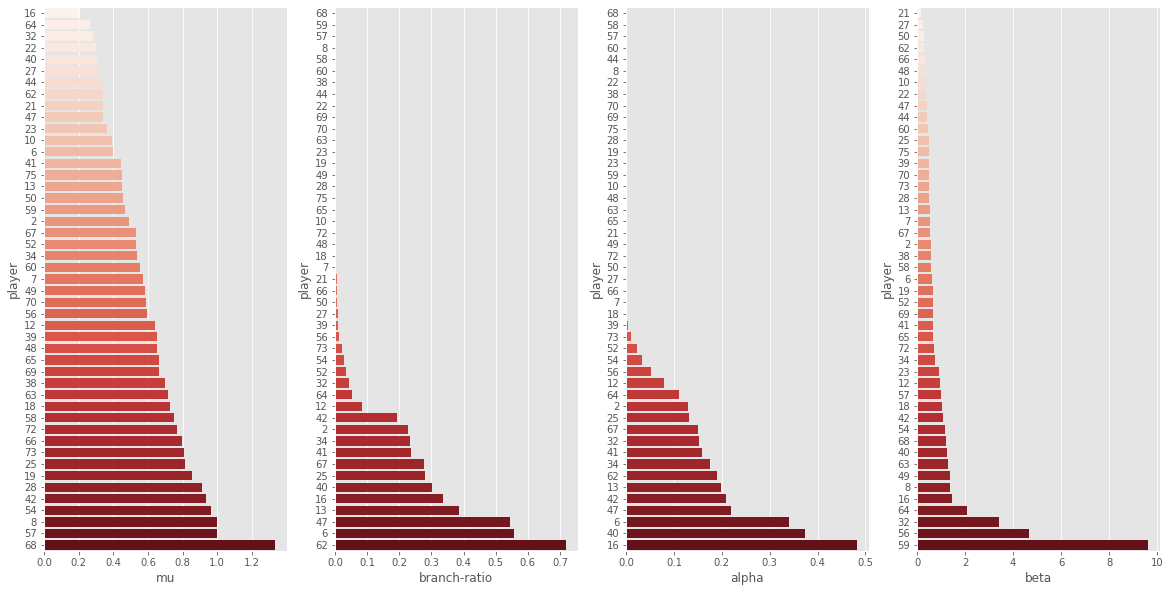

In [449]:
#plotting
theme = 'Reds' #'Blues'
df=df_org
df['player'] = df_org['player'].str.replace("Player ","")
f, axes = plt.subplots(1, 4,figsize=(20,10))
sns.barplot(x='mu', y='player', data=df.sort_values('mu', ascending=True), palette=theme, ax=axes[0])
#plt.ylabel('players', fontsize=12)
plt.xlabel('mu', fontsize=12)
plt.xticks(rotation='horizontal')

sns.barplot(x='branch-ratio', y='player', data=df.sort_values('branch-ratio', ascending=True), palette=theme, ax=axes[1])
plt.ylabel('players', fontsize=12)
plt.xlabel('branch-ratio', fontsize=12)
plt.xticks(rotation='horizontal')

sns.barplot(x='alpha', y='player', data=df.sort_values('alpha', ascending=True), palette=theme, ax=axes[2])
#plt.ylabel('players', fontsize=12)
plt.xlabel('alpha', fontsize=12)
plt.xticks(rotation='horizontal')
           
sns.barplot(x='beta', y='player', data=df.sort_values('beta', ascending=True), palette=theme, ax=axes[3])
#plt.ylabel('players', fontsize=12)
plt.xlabel('beta', fontsize=12)
plt.xticks(rotation='horizontal')

(array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. ]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

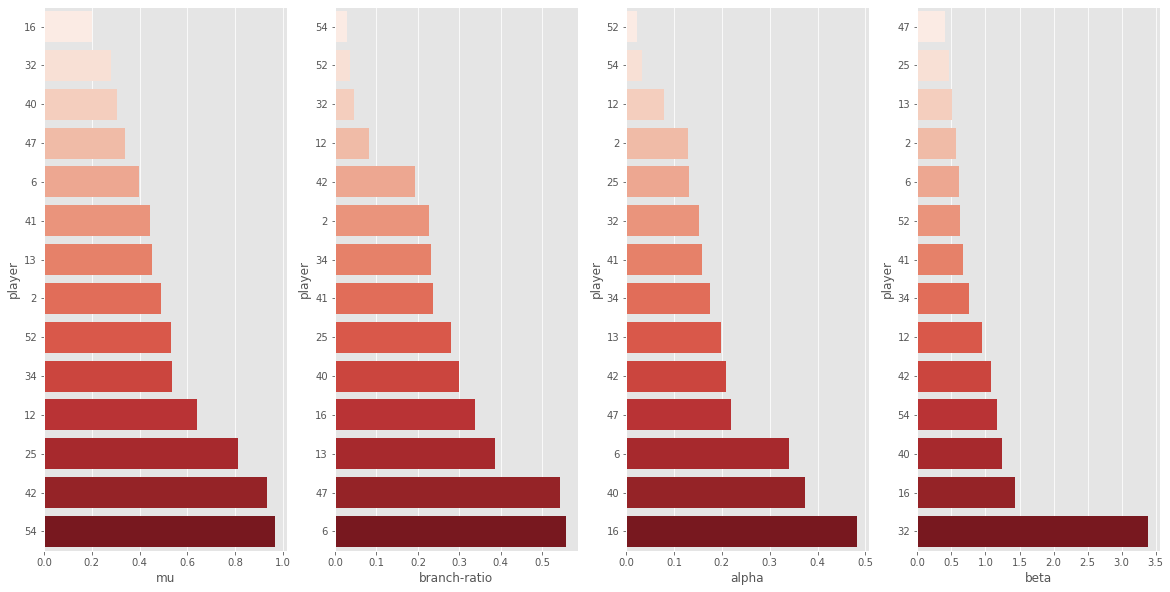

In [451]:
theme = 'Reds' #Blues
keep_list = ['12', '13', '16', '2', '25', '32', '34', '40', '41', '42', '47', '52', '54','6']
df = df[df['player'].isin(keep_list)]
f, axes = plt.subplots(1, 4,figsize=(20,10))
sns.barplot(x='mu', y='player', data=df.sort_values('mu', ascending=True), palette=theme, ax=axes[0])
#plt.ylabel('players', fontsize=12)
plt.xlabel('mu', fontsize=12)
plt.xticks(rotation='horizontal')

sns.barplot(x='branch-ratio', y='player', data=df.sort_values('branch-ratio', ascending=True), palette=theme, ax=axes[1])
plt.ylabel('players', fontsize=12)
plt.xlabel('branch-ratio', fontsize=12)
plt.xticks(rotation='horizontal')

sns.barplot(x='alpha', y='player', data=df.sort_values('alpha', ascending=True), palette=theme, ax=axes[2])
#plt.ylabel('players', fontsize=12)
plt.xlabel('alpha', fontsize=12)
plt.xticks(rotation='horizontal')
           
sns.barplot(x='beta', y='player', data=df.sort_values('beta', ascending=True), palette=theme, ax=axes[3])
#plt.ylabel('players', fontsize=12)
plt.xlabel('beta', fontsize=12)
plt.xticks(rotation='horizontal')